# Coupled Oscillator Model parameter optimization with UKF on fMRI data

## Libraries

-   KernSmooth: Kernel smoothing on voxel data
-   deSolve: Solve ODEs
-   ggplot2: Plotting
-   UKF (https://github.com/insilico/UKF)
-   data.table
-   dplyr
-   tidyr

In [ ]:
library(KernSmooth)
library(deSolve)
library(ggplot2)
#library(devtools)
#install_github("insilico/UKF")  
library(UKF)
#install.packages(c('KernSmooth'))
library(data.table)
library(dplyr)
library(tidyr)
# hide warnings
options(warn=-1)

Warning message:
"package 'KernSmooth' was built under R version 4.2.3"
KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Warning message:
"package 'deSolve' was built under R version 4.2.3"
Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Warning message:
"package 'data.table' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




## Functions

### Chi square loss plot

In [25]:
plot_ukf_chi_square_loss <- function(ukf_output, title = "UKF Chi-Square Loss Over Time") {
  if (is.null(ukf_output$chisq)) {
    stop("The UKF output does not contain a 'loss' or 'chi-square loss' component.")
  }

  # Create a dataframe for plotting
  loss_df <- data.frame(
    Time = seq_along(ukf_output$chisq),
    ChiSquareLoss = ukf_output$chisq
  )

  # Plot using ggplot2
  library(ggplot2)
  ggplot(loss_df, aes(x = Time, y = ChiSquareLoss)) +
    geom_line(color = "#2C3E50", size = 1) +
    labs(
      title = title,
      x = "Time Step",
      y = expression(Chi^2~Loss)
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5),
      axis.title = element_text(face = "bold")
    )
}

### Iterative parameter optimization with best parameter tracing

In [12]:
iterative_param_optim_trace <- function(param_guess,
                                        t_dummy, ts_data, ode_model,
                                        N_p, N_y, dt, dT,
                                        param_tol = 0.01, MAXSTEPS = 30, forcePositive = FALSE) {
  done <- FALSE
  steps <- 0
  chisq_history <- numeric()  # Store chi-square values for each iteration

  # Initialize best parameter tracking
  best_param <- param_guess
  best_chisq <- Inf
  best_xhat <- NULL

  while (!done) {
    # One run through whole time series
    ukf_run <- UKF_blend(t_dummy, ts_data,
                         ode_model,
                         N_p, N_y, param_guess, dt, dT, forcePositive = forcePositive)

    param_new <- ukf_run$param_est
    chisq_history <- c(chisq_history, ukf_run$chisq)  # Append chi-square

    # Track best parameters
    if (ukf_run$chisq < best_chisq) {
      best_chisq <- ukf_run$chisq
      best_param <- param_new
      best_xhat <- ukf_run$xhat
    }

    steps <- steps + 1
    param_norm <- abs(sum(param_new - param_guess))
    converged <- param_norm < param_tol
    done <- converged | steps >= MAXSTEPS

    param_guess <- param_new  # Update guess for next iteration
  }

  # Return best parameters and trace
  return(list(
    par = best_param,
    value = best_chisq,
    param_norm = param_norm,
    steps = steps,
    param_est = best_param,
    xhat = best_xhat,
    chisq_trace = chisq_history  # chi-square over iterations
      ))
}

## Coupled Oscillator Model - Two Coupled Pendulums

The equation of motion of the combined system is then given by: 
$$L \ddot{\theta_{1}} =-g \sin \theta_{1}-k L\left(\sin \theta_{1}-\sin \theta_{2}\right),$$
$$L \ddot{\theta_{2}} =-g \sin \theta_{2}+k L\left(\sin \theta_{1}-\sin \theta_{2}\right)$$

There are 3 parameters in the equation:
- g, gravity
- L, length of pendulums ($L_1$ and $L_2$)
- k, spring constant

coupled_osc_model optimize 3 parameters; g, L and k

coupled_osc_model_fixed optimize only k

In [3]:
# Coupled oscillator model for UKF (state-space form)
coupled_osc_model <- function(t, x, p) {
  # Parameters
  g <- p[1,]
  L <- p[2,]
  k <- p[3,]
  # State variables
  theta1 <- x[1,]
  theta2 <- x[2,]
  
  # Equations of motion (from LaTeX)
  theta1_dot_dot <- (-g * sin(theta1) - k * L * (sin(theta1) - sin(theta2))) / L
  theta2_dot_dot <- (-g * sin(theta2) + k * L * (sin(theta1) - sin(theta2))) / L
  
  return(rbind(theta1_dot_dot, theta2_dot_dot))
}

# Coupled oscillator model for ODE solver (deSolve)
coupled_osc_model_ode <- function(t, state, parameters) {
  with(as.list(c(state, parameters)), {
    theta1_dot <- state[2]  # velocity of pendulum 1
    theta2_dot <- state[4]  # velocity of pendulum 2
    theta1_dot_dot <- (-g * sin(theta1) - k * L * (sin(theta1) - sin(theta2))) / L
    theta2_dot_dot <- (-g * sin(theta2) + k * L * (sin(theta1) - sin(theta2))) / L
    return(list(c(theta1_dot, theta1_dot_dot, theta2_dot, theta2_dot_dot)))
  })
}

# Modified the model function to accept only k as a parameter
coupled_osc_model_fixed <- function(t, x, k) {
  g <- g_fixed
  L <- L_fixed
  k <- k
  theta1 <- x[1,]
  theta2 <- x[2,]
  theta1_dot_dot <- (-g * sin(theta1) - k * L * (sin(theta1) - sin(theta2))) / L
  theta2_dot_dot <- (-g * sin(theta2) + k * L * (sin(theta1) - sin(theta2))) / L
  return(rbind(theta1_dot_dot, theta2_dot_dot))
}

With the specific initial conditions: 
- Leave pendulum number 2 at rest in its equilibrium position $(\theta_2(0)=\dot{\theta_2}(0)=0)$ 
- Give pendulum number 1 a finite amplitude but also release it at rest $(\theta_1(0)=\theta_0,\dot{\theta_1}(0)=0)$.

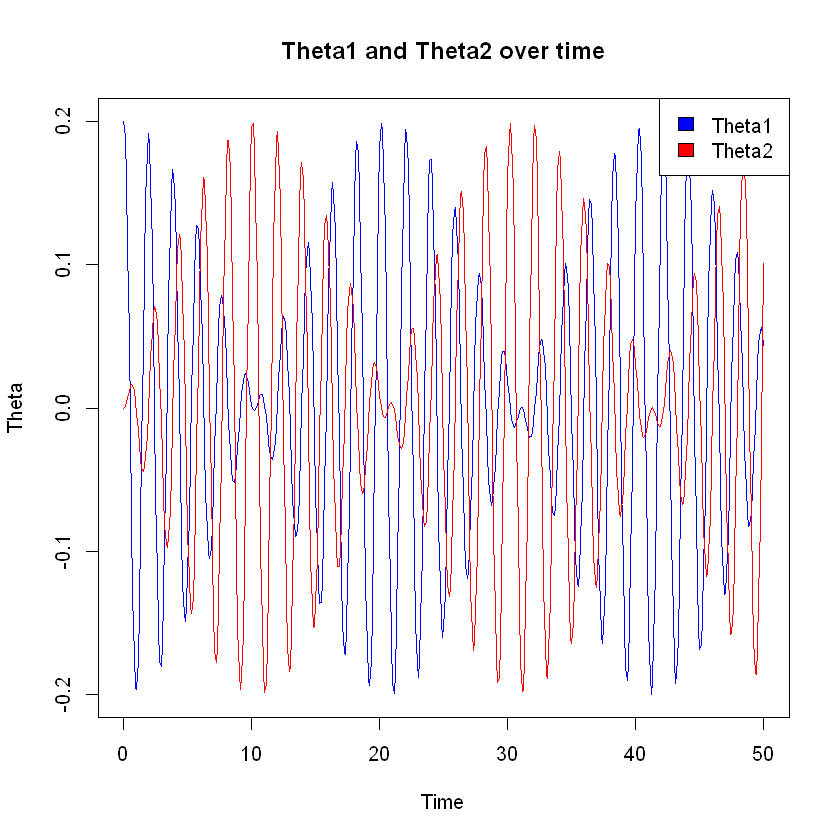

In [4]:
times <- seq(0, 50, by = .1)
init <- c(theta1 = 0.2, theta1_dot = 0, theta2 = 0, theta2_dot = 0)
parameters <- c(g = 9.81, L = 1, k = 1)
out <- ode(y = init, times = times, func = coupled_osc_model_ode, parms = parameters)
out <- as.data.frame(out)

plot(out$time, out$theta1, type = "l", ylab = "Theta", xlab = "Time", col = "blue", main = "Theta1 and Theta2 over time")
lines(out$time, out$theta2, col = "red")
legend("topright", legend = c("Theta1", "Theta2"), fill = c("blue", "red"))

## fMRI Data

### Voxel A & B data

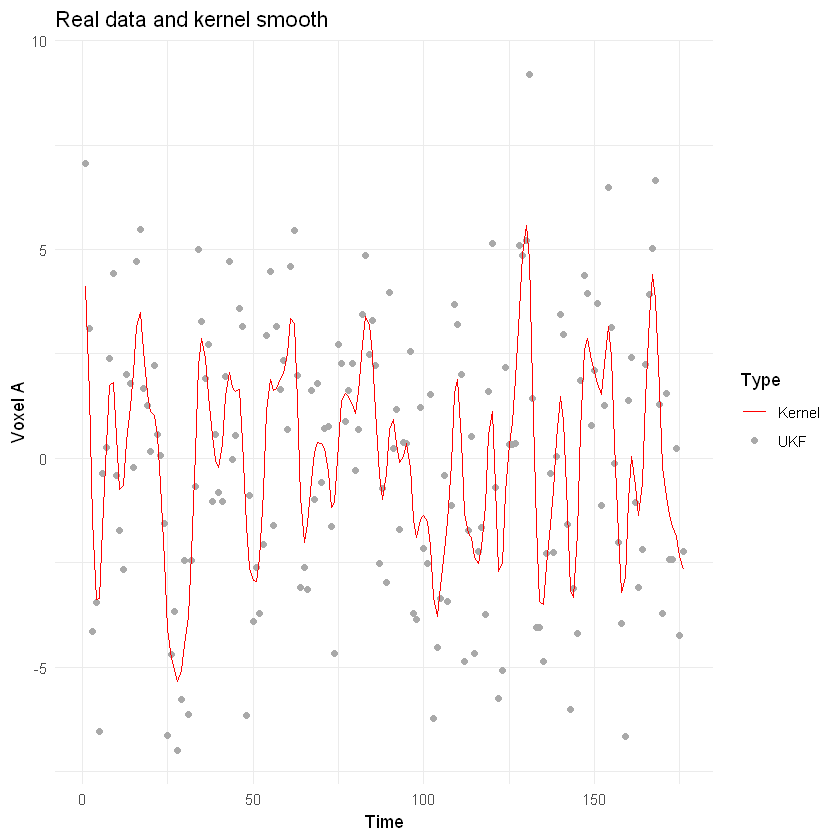

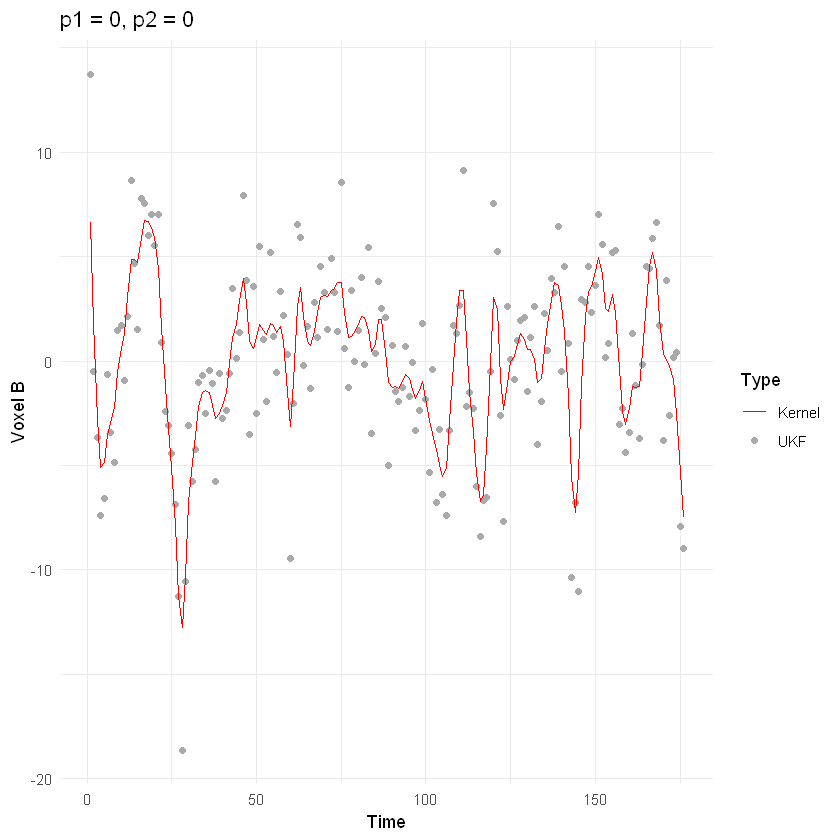

In [5]:
vox.A.B.data <- read.delim("data/voxel_A&B_data.txt",sep="",header=F)
# make column-wise
vox.A.B.data <- t(vox.A.B.data)
smoothed_data <- plot_voxels_and_smooth_ggplot(vox.A.B.data)

### Iterative optimization with voxelAB

Iterative Parameter Optimization Results:
Estimated Parameters:
 g  :  125.8063 
 L :  262.2463 
 k  :  368.8031 

Chi-Square Value:  14.57754
Number of Steps:  100
Parameter Norm:  10.22522


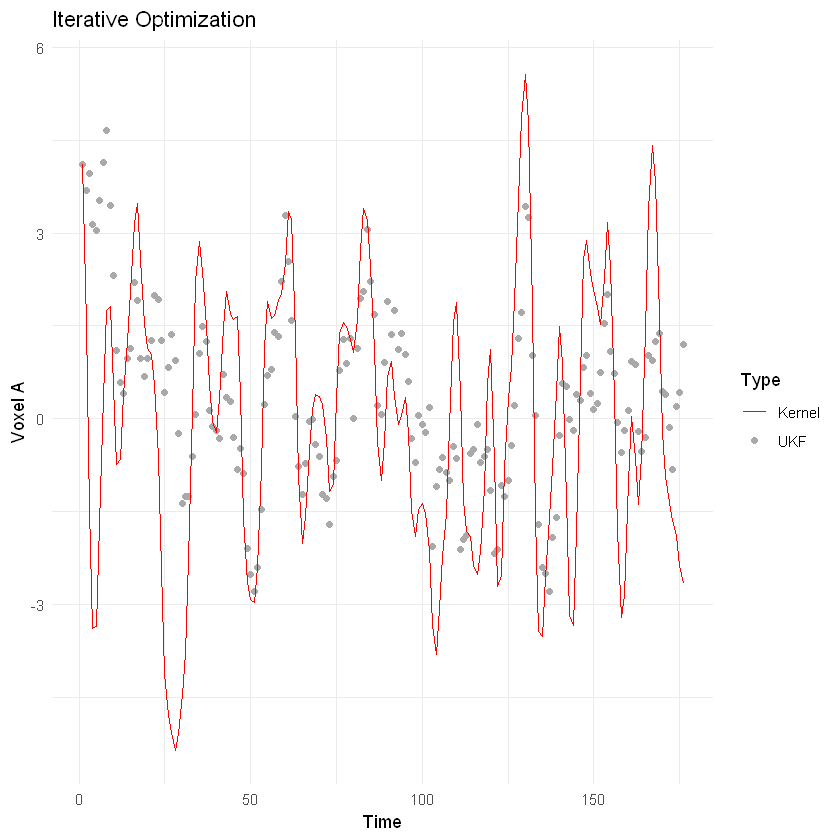

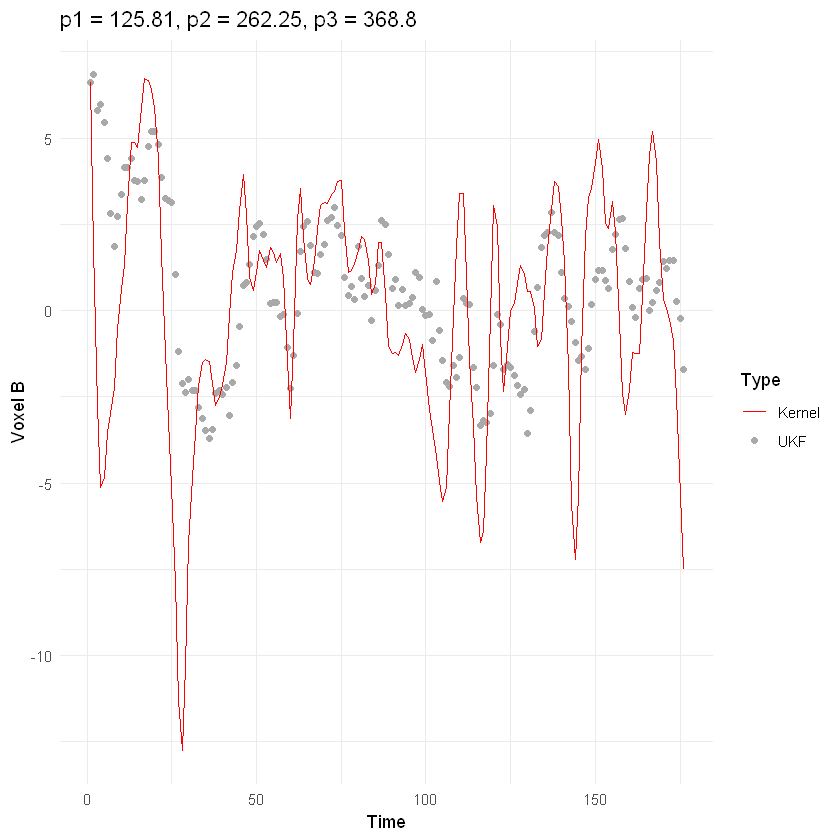

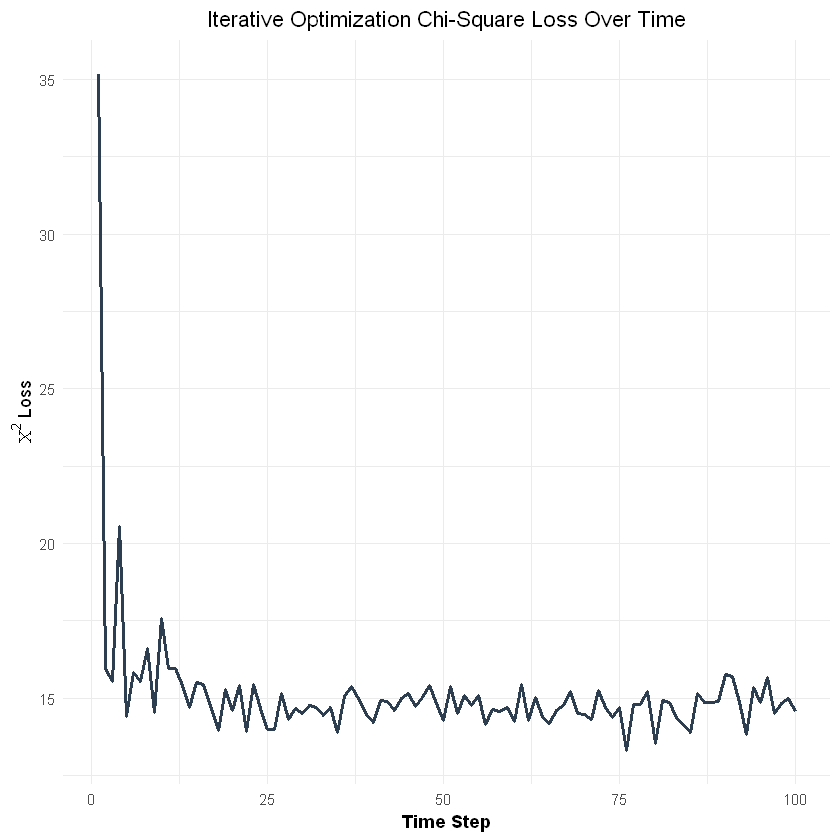

In [6]:
t_vec <- vox.A.B.data[,1] # time is first column
dT <- t_vec[2]-t_vec[1]   # assume uniform time steps dT=1
# smaller steps size for propagating model between dT steps
dt <- 0.1*dT
# num observed ind vars, first col is time, so -1
N_y <- ncol(vox.A.B.data)-1  # N_y=2
# number of unknown model parameters to be estimated
N_p <- 3
# size of augmented state vector
N_x <- N_p + N_y
param_guess <- c(10,10,40) # g, L, k
# Perform iterative parameter optimization
iter_opt <- iterative_param_optim(param_guess, t_dummy, smoothed_data, coupled_osc_model, N_p, N_y, dt, dT,
                                  param_tol = .01, MAXSTEPS = 100)

cat("Iterative Parameter Optimization Results:\n")
cat("=========================================\n")
cat("Estimated Parameters:\n")
cat(" g  : ", iter_opt$param_est[1], "\n")
cat(" L : ", iter_opt$param_est[2], "\n")
cat(" k  : ", iter_opt$param_est[3], "\n")
cat("\nChi-Square Value: ", iter_opt$value)
cat("\nNumber of Steps: ", iter_opt$steps)
cat("\nParameter Norm: ", iter_opt$param_norm)
cat("\n=========================================\n")

# Plot the results
plot_ukf_and_smoothed_ggplot(iter_opt, smoothed_data, top_title = 'Iterative Optimization')
plot_ukf_chi_square_loss(iter_opt, title = "Iterative Optimization Chi-Square Loss Over Time")

Iterative Parameter Optimization Results:
Estimated Parameters:
 k  :  17.38782 

Chi-Square Value:  99.79478
Number of Steps:  14
Parameter Norm:  0.009253708


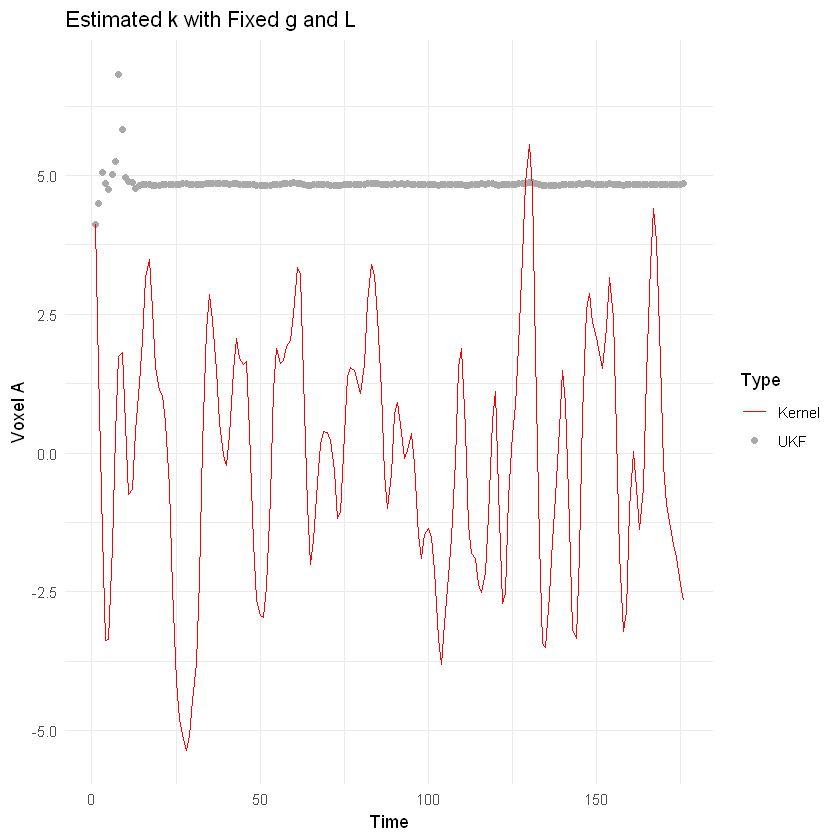

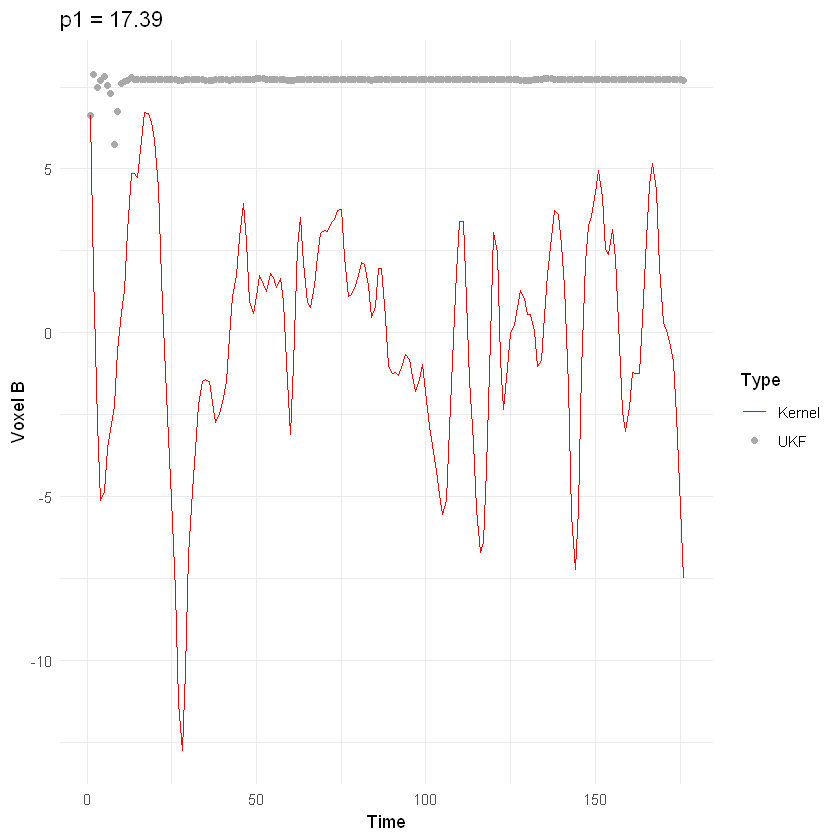

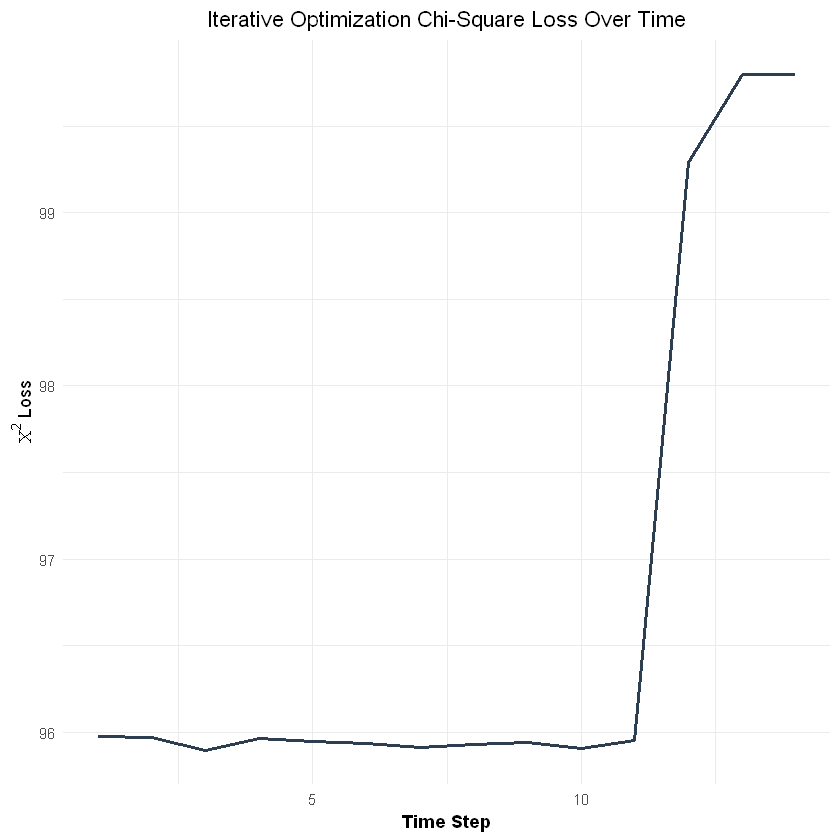

In [7]:
# Set fixed parameters
g_fixed <- 9.81
L_fixed <- 1

# Only k is to be estimated
param_guess <- 10  # Initial guess for k
# Set up UKF parameters
N_p <- 1  # Only k
N_y <- ncol(vox.A.B.data) - 1
dt <- 0.1 * (vox.A.B.data[2,1] - vox.A.B.data[1,1])
dT <- vox.A.B.data[2,1] - vox.A.B.data[1,1]

# Run UKF iterative parameter optimization
iter_opt <- iterative_param_optim(
  param_guess, t_dummy, smoothed_data, coupled_osc_model_fixed,
  N_p, N_y, dt, dT, param_tol = 0.01, MAXSTEPS = 1000
)

cat("Iterative Parameter Optimization Results:\n")
cat("=========================================\n")
cat("Estimated Parameters:\n")
cat(" k  : ", iter_opt$param_est[1], "\n")
cat("\nChi-Square Value: ", iter_opt$value)
cat("\nNumber of Steps: ", iter_opt$steps)
cat("\nParameter Norm: ", iter_opt$param_norm)
cat("\n=========================================\n")

# Plot results
plot_ukf_and_smoothed_ggplot(iter_opt, smoothed_data, top_title = 'Estimated k with Fixed g and L')
plot_ukf_chi_square_loss(iter_opt, title = "Iterative Optimization Chi-Square Loss Over Time")

### ASD dataset - Harvard-Oxford atlas

In [8]:
smooth_subject_data <- function(subject_df, bandwidth = NULL) {
  # Ensure the first column is time
  time_vec <- subject_df$Time
  region_cols <- subject_df[, -1]
  
  n <- nrow(subject_df)
  m_points <- seq(1, n, by = 1)
  
  # Apply kernel smoothing to each region
  smoothed_regions <- apply(region_cols, 2, function(region_signal) {
    # Determine bandwidth if not provided
    h <- if (is.null(bandwidth)) {
      tryCatch({
        dpill(m_points, region_signal)
      }, error = function(e) {
        message("Warning in dpill: ", e$message)
        return(0.5)  # Default fallback bandwidth
      })
    } else {
      bandwidth
    }
    
    # Apply ksmooth
    smooth_result <- ksmooth(m_points, region_signal, kernel = "normal", bandwidth = h, n.points = n)
    return(smooth_result$y)
  })
  
  # Combine time and smoothed signals
  smoothed_df <- data.frame(Time = time_vec, smoothed_regions)
  colnames(smoothed_df) <- colnames(subject_df)
  
  return(smoothed_df)
}

load_subject_data <- function(file_path, region_labels) {
  df <- fread(file_path, header = TRUE, check.names = FALSE, data.table = FALSE)
  header <- colnames(df)
  colnames(df)[1] <- "Time"
  
  # Strip '#' from column names and convert to match RegionCode
  region_codes <- gsub("#", "", header[-1])  # Exclude Time
  region_names <- region_labels$RegionName[match(region_codes, region_labels$RegionCode)]
  
  # Handle missing labels
  # region_names[is.na(region_names)] <- paste0("Unknown_", region_codes[is.na(region_names)])
  
  # Rename columns
  colnames(df)[-1] <- region_names
  df[] <- lapply(df, as.numeric)  # Convert all data to numeric
  return(df)
}

# Reshape for plotting
reshape_subject_data <- function(subject_list, group_label) {
  bind_rows(lapply(seq_along(subject_list), function(i) {
    df <- subject_list[[i]]
    df_long <- pivot_longer(df, -Time, names_to = "RegionName", values_to = "Signal")
    df_long$Subject <- paste0(group_label, "_", i)
    df_long$Group <- group_label
    return(df_long)
  }))
}

# Function to apply smoothing across all subjects and convert to long format
smooth_all_subjects_to_long <- function(subject_list, group_label, bandwidth = 0.6) {
  smoothed_long_list <- lapply(seq_along(subject_list), function(i) {
    subj_name <- paste0(group_label, "_", i)
    wide_data <- subject_list[[i]]
    
    smoothed_data <- smooth_subject_data(wide_data, bandwidth = bandwidth)
    smoothed_data$Time <- as.numeric(wide_data$Time)  # Add time back for reshaping
    
    # Convert to long format
    smoothed_long <- pivot_longer(smoothed_data, -Time, names_to = "RegionName", values_to = "SmoothedSignal")
    smoothed_long$Subject <- subj_name
    smoothed_long$Group <- group_label
    return(smoothed_long)
  })
  
  # Combine all
  bind_rows(smoothed_long_list)
}

# File paths
asd_dir <- "data/Training Data/ASD"
normal_dir <- "data/Training Data/Normal"
label_file <- "data/Label of Brain Regions.csv"

# Load brain region labels
region_labels <- read.csv(label_file, header = TRUE, stringsAsFactors = FALSE)
colnames(region_labels) <- c("RegionCode", "RegionName")
region_labels$RegionCode <- as.character(region_labels$RegionCode)

# Load all subjects
asd_files <- list.files(asd_dir, full.names = TRUE, pattern = "*.csv")
normal_files <- list.files(normal_dir, full.names = TRUE, pattern = "*.csv")

asd_data_list <- lapply(asd_files, load_subject_data, region_labels = region_labels)
normal_data_list <- lapply(normal_files, load_subject_data, region_labels = region_labels)

names(asd_data_list) <- paste0("ASD_", seq_along(asd_data_list))
names(normal_data_list) <- paste0("Normal_", seq_along(normal_data_list))

# Prepare long-format data
asd_long <- reshape_subject_data(asd_data_list, "ASD")
normal_long <- reshape_subject_data(normal_data_list, "Normal")
all_data_long <- rbind(asd_long, normal_long)

In [23]:
# 1. Extract ASD subject 1's data for the first two brain regions
asd1_long <- subset(all_data_long, Subject == "ASD_1")

# Get the names of the first two brain regions
region_names <- unique(asd1_long$RegionName)
region1 <- region_names[1]
region2 <- region_names[2]

# 2. Filter for just those two regions and reshape to wide format
asd1_wide <- asd1_long %>%
  filter(RegionName %in% c(region1, region2)) %>%
  select(Time, RegionName, Signal) %>%
  pivot_wider(names_from = RegionName, values_from = Signal)

# 3. Smooth the signals
smoothed_asd1 <- smooth_subject_data(asd1_wide, bandwidth = 0.7)

# 4. Prepare data for UKF (Time, Region1, Region2)
ukf_data <- as.matrix(smoothed_asd1)

Iterative Parameter Optimization Results:
Estimated Parameters:
 g  :  25.85544 
 L :  9.189006 
 k  :  17.49393 

Chi-Square Value:  309.4349
Number of Steps:  47
Parameter Norm:  0.0007304675


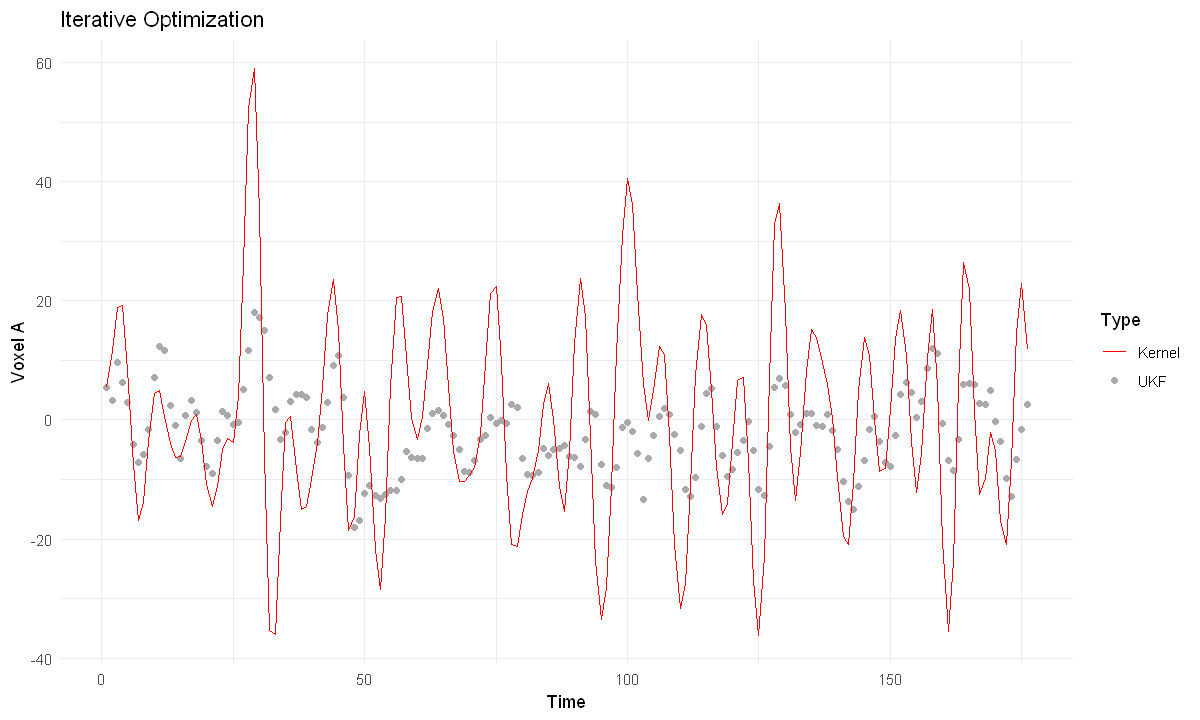

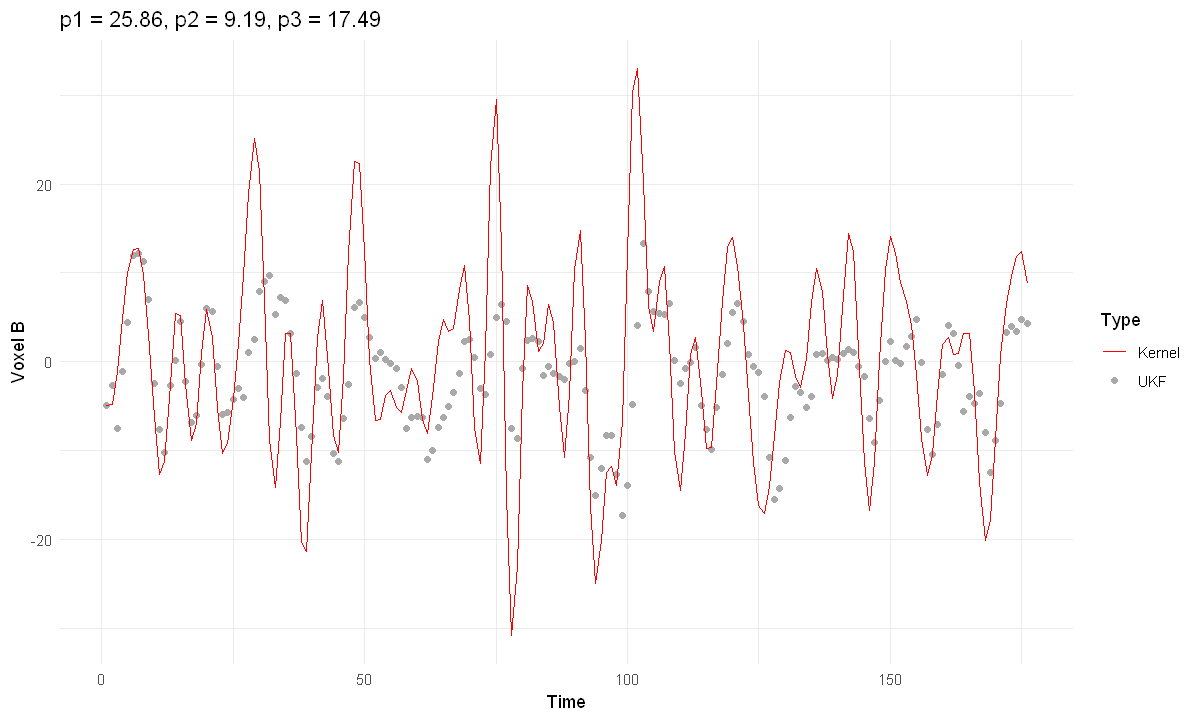

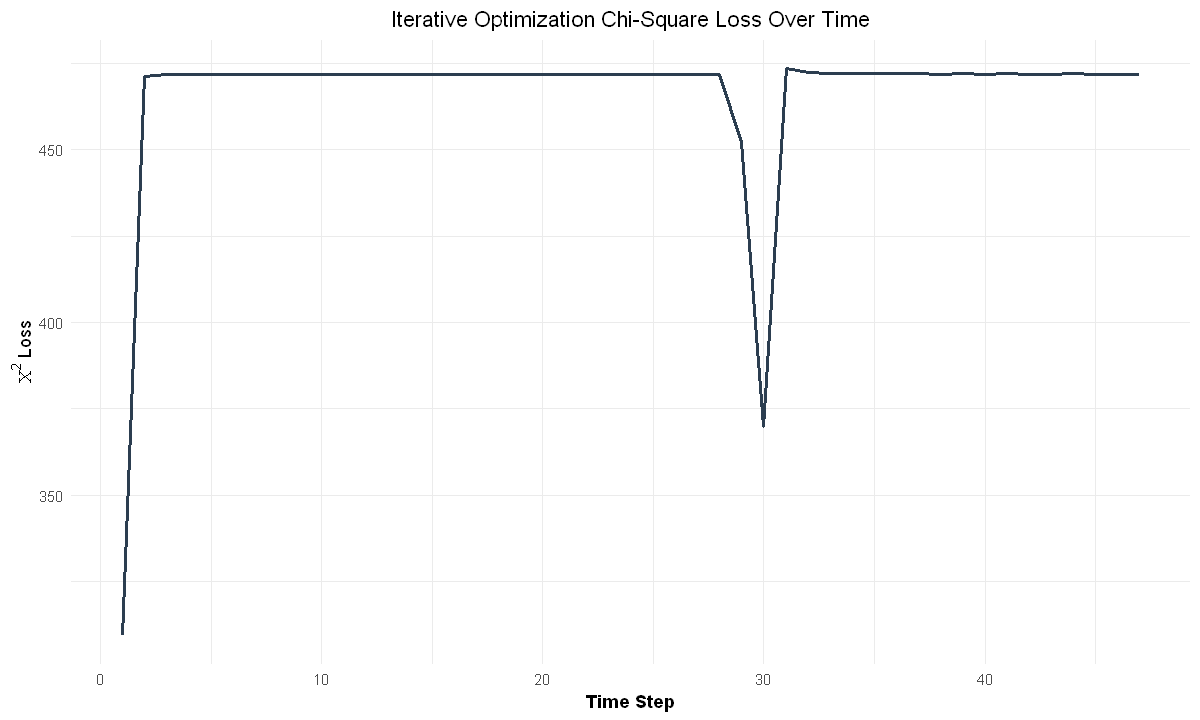

In [35]:
t_vec <- ukf_data[,1] # time is first column
dT <- t_vec[2]-t_vec[1]   # assume uniform time steps dT=1
# smaller steps size for propagating model between dT steps
dt <- 0.1*dT
# num observed ind vars, first col is time, so -1
N_y <- ncol(ukf_data)-1  # N_y=2
# number of unknown model parameters to be estimated
N_p <- 3
# size of augmented state vector

param_guess <- c(10,10,40) # g, L, k
# Perform iterative parameter optimization
iter_opt <- iterative_param_optim_trace(param_guess, t_dummy, ukf_data, coupled_osc_model, N_p, N_y, dt, dT,
                                  param_tol = 1e-3, MAXSTEPS = 1000, forcePositive = TRUE)

cat("Iterative Parameter Optimization Results:\n")
cat("=========================================\n")
cat("Estimated Parameters:\n")
cat(" g  : ", iter_opt$param_est[1], "\n")
cat(" L : ", iter_opt$param_est[2], "\n")
cat(" k  : ", iter_opt$param_est[3], "\n")
cat("\nChi-Square Value: ", iter_opt$value)
cat("\nNumber of Steps: ", iter_opt$steps)
cat("\nParameter Norm: ", iter_opt$param_norm)
cat("\n=========================================\n")

# Plot the results
plot_ukf_and_smoothed_ggplot(iter_opt, ukf_data, top_title = 'Iterative Optimization')
plot_ukf_chi_square_loss(iter_opt, title = "Iterative Optimization Chi-Square Loss Over Time")

tolerance 0.001 and higher yield early stops

3 parameter estimation, tolerance = 0.0001, Maximum #iterations = 1000, 3.55 mins runtime

Iterative Parameter Optimization Results:
Estimated Parameters:
 g  :  25.85544 
 L :  9.189006 
 k  :  17.49393 

Chi-Square Value:  309.4349
Number of Steps:  1000
Parameter Norm:  0.03069854


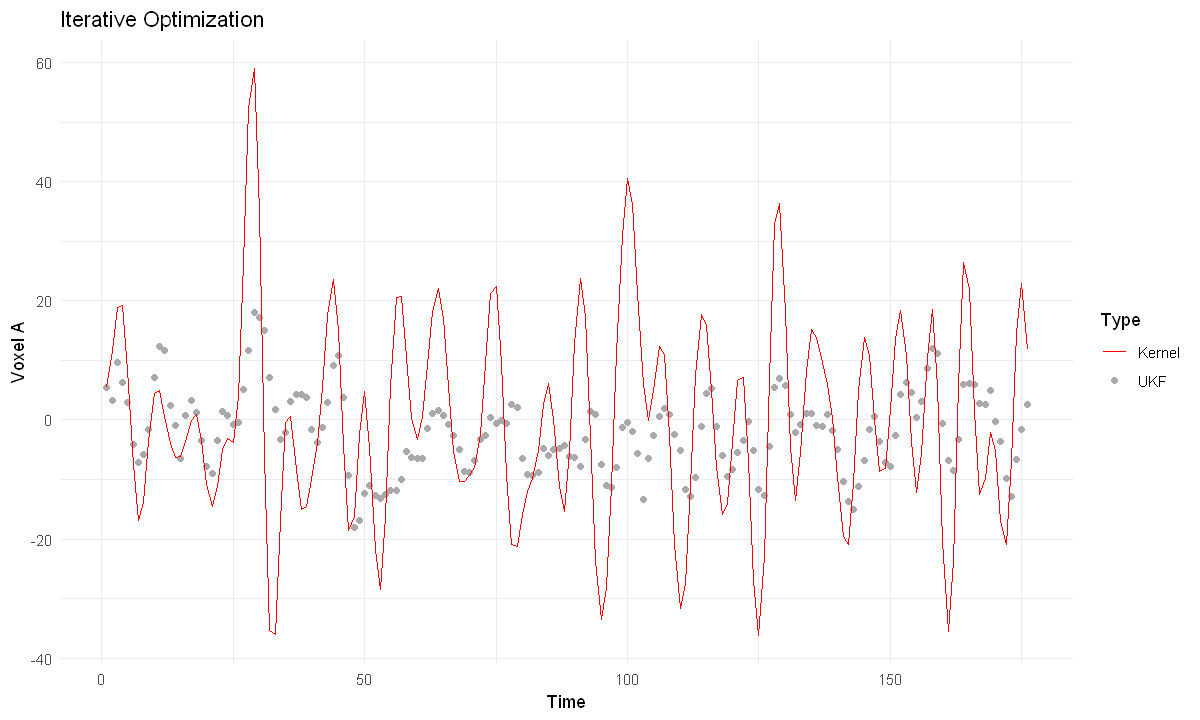

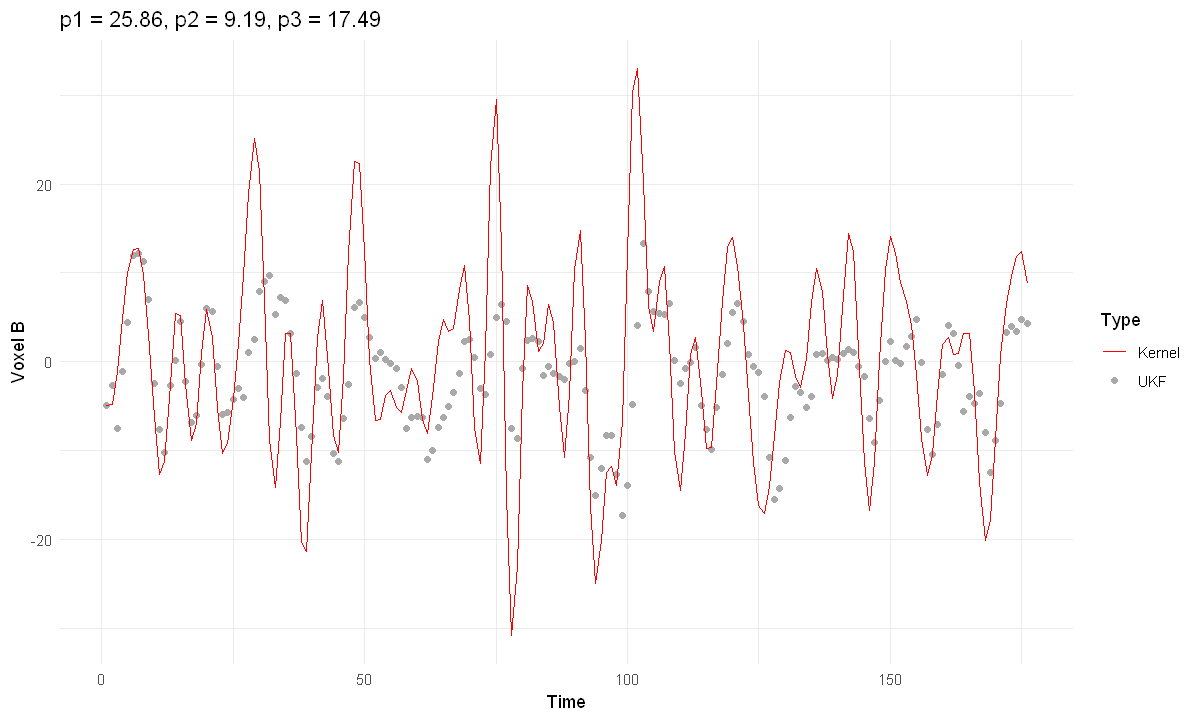

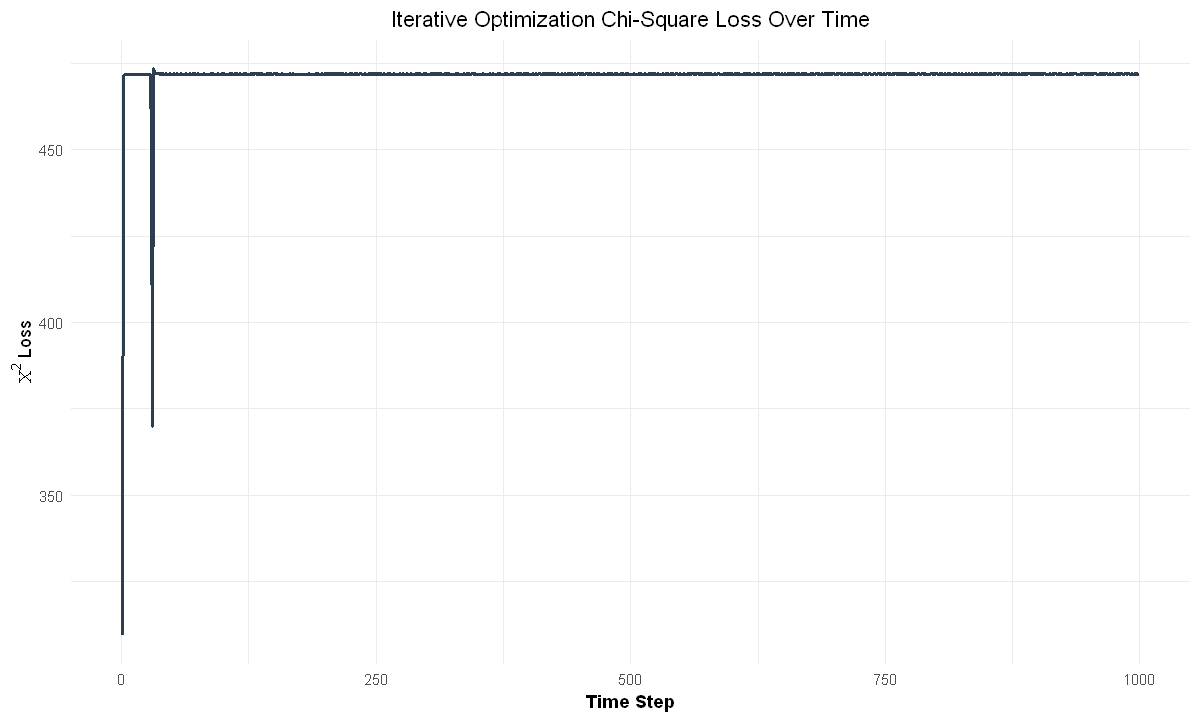

In [ ]:
t_vec <- ukf_data[,1]
dT <- t_vec[2]-t_vec[1]
dt <- 0.1*dT
N_y <- ncol(ukf_data)-1
N_p <- 3
param_guess <- c(10,10,40) # g, L, k
# Perform iterative parameter optimization
iter_opt <- iterative_param_optim_trace(param_guess, t_dummy, ukf_data, coupled_osc_model, N_p, N_y, dt, dT,
                                  param_tol = 1e-4, MAXSTEPS = 1000, forcePositive = TRUE)

cat("Iterative Parameter Optimization Results:\n")
cat("=========================================\n")
cat("Estimated Parameters:\n")
cat(" g  : ", iter_opt$param_est[1], "\n")
cat(" L : ", iter_opt$param_est[2], "\n")
cat(" k  : ", iter_opt$param_est[3], "\n")
cat("\nChi-Square Value: ", iter_opt$value)
cat("\nNumber of Steps: ", iter_opt$steps)
cat("\nParameter Norm: ", iter_opt$param_norm)
cat("\n=========================================\n")

# Plot the results
plot_ukf_and_smoothed_ggplot(iter_opt, ukf_data, top_title = 'Iterative Optimization')
plot_ukf_chi_square_loss(iter_opt, title = "Iterative Optimization Chi-Square Loss Over Time")

3 parameter estimation, tolerance = 0.0001, Maximum #iterations = 1000 completed the number of steps, therefore there's still uncovered search space. Increase #iterations for the next set

3 parameter estimation, tolerance = 0.0001, Maximum #iterations = 10000, 5.10 mins runtime

Iterative Parameter Optimization Results:
Estimated Parameters:
 g  :  25.85544 
 L :  9.189006 
 k  :  17.49393 

Chi-Square Value:  309.4349
Number of Steps:  1353
Parameter Norm:  4.663846e-05


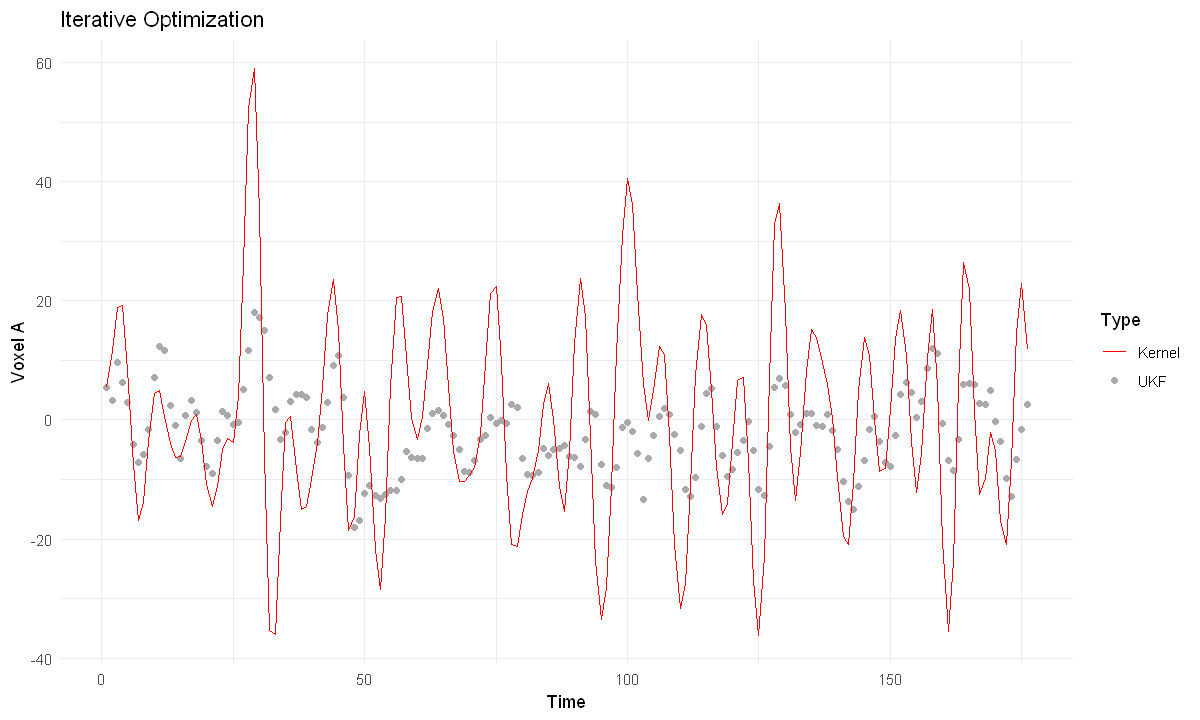

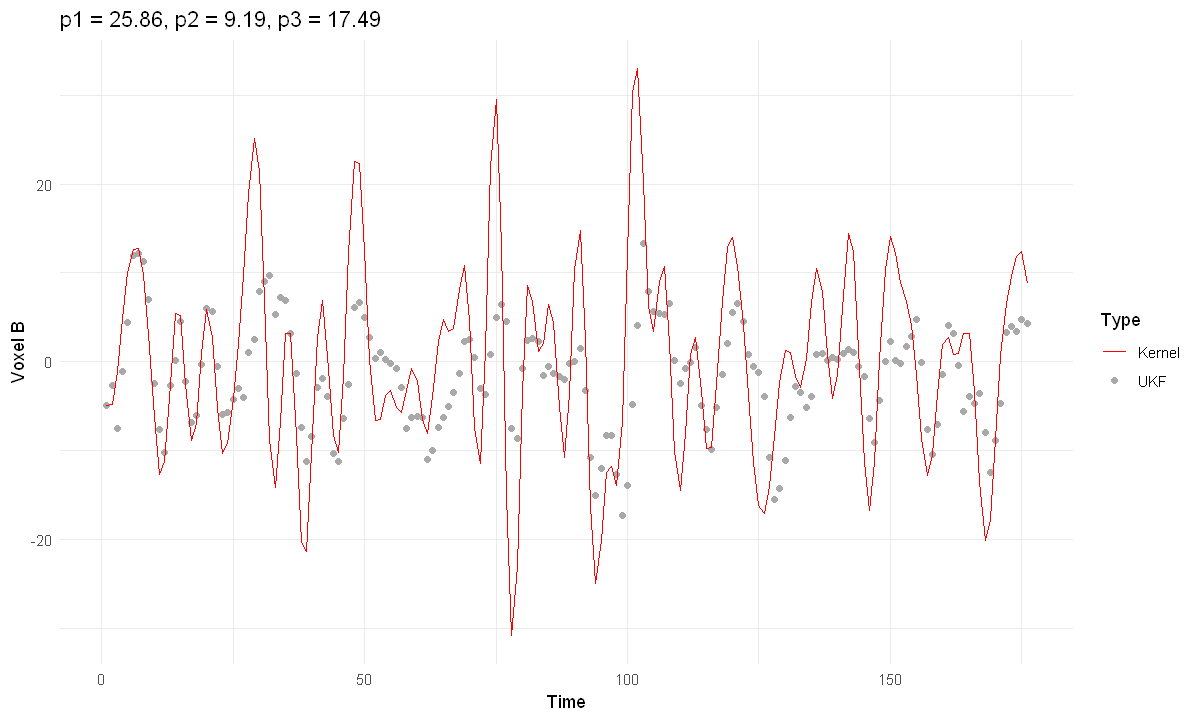

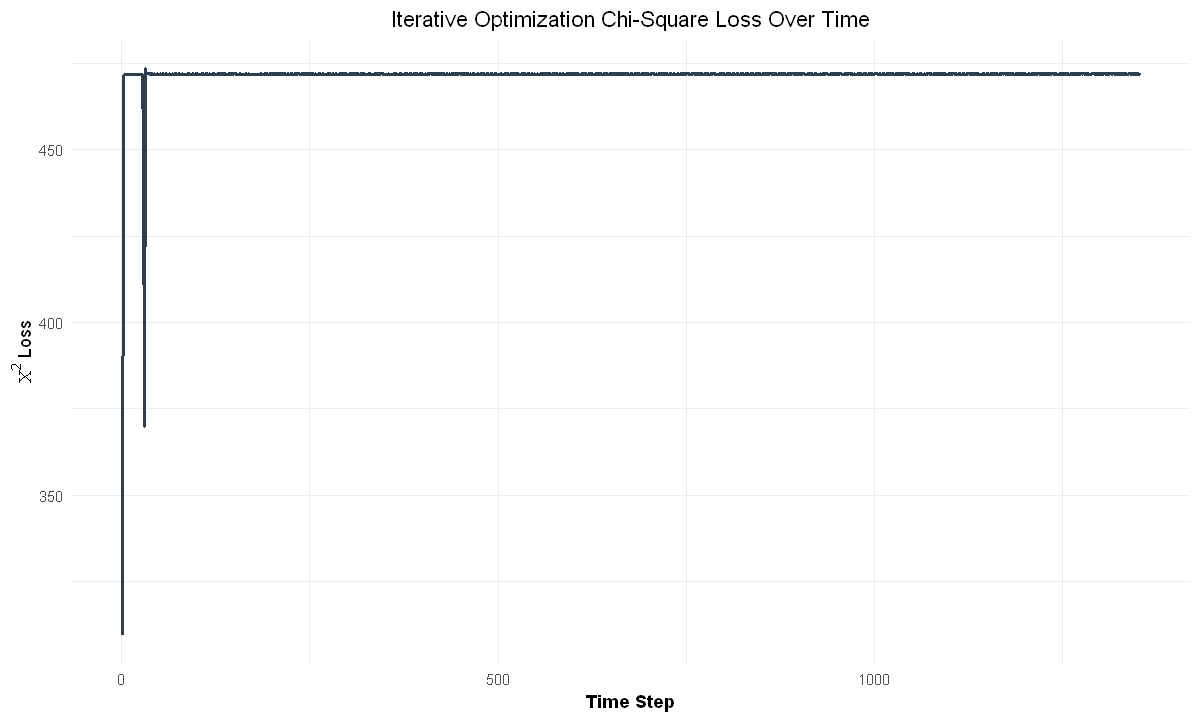

In [ ]:
t_vec <- ukf_data[,1]
dT <- t_vec[2]-t_vec[1]
dt <- 0.1*dT
N_y <- ncol(ukf_data)-1
N_p <- 3
param_guess <- c(10,10,40) # g, L, k
iter_opt <- iterative_param_optim_trace(param_guess, t_dummy, ukf_data, coupled_osc_model, N_p, N_y, dt, dT,
                                  param_tol = 1e-4, MAXSTEPS = 10000, forcePositive = TRUE)

cat("Iterative Parameter Optimization Results:\n")
cat("=========================================\n")
cat("Estimated Parameters:\n")
cat(" g  : ", iter_opt$param_est[1], "\n")
cat(" L : ", iter_opt$param_est[2], "\n")
cat(" k  : ", iter_opt$param_est[3], "\n")
cat("\nChi-Square Value: ", iter_opt$value)
cat("\nNumber of Steps: ", iter_opt$steps)
cat("\nParameter Norm: ", iter_opt$param_norm)
cat("\n=========================================\n")

# Plot the results
plot_ukf_and_smoothed_ggplot(iter_opt, ukf_data, top_title = 'Iterative Optimization')
plot_ukf_chi_square_loss(iter_opt, title = "Iterative Optimization Chi-Square Loss Over Time")

3 parameter estimation, tolerance = 0.0001, Maximum #iterations = 10000 converged at 1353th iteration. Decrease the tolerance to 0.00001

3 parameter estimation, tolerance = 0.00001, Maximum #iterations = 10000, 39,23 mins runtime

Iterative Parameter Optimization Results:
Estimated Parameters:
 g  :  25.85544 
 L :  9.189006 
 k  :  17.49393 

Chi-Square Value:  309.4349
Number of Steps:  10000
Parameter Norm:  0.3669116


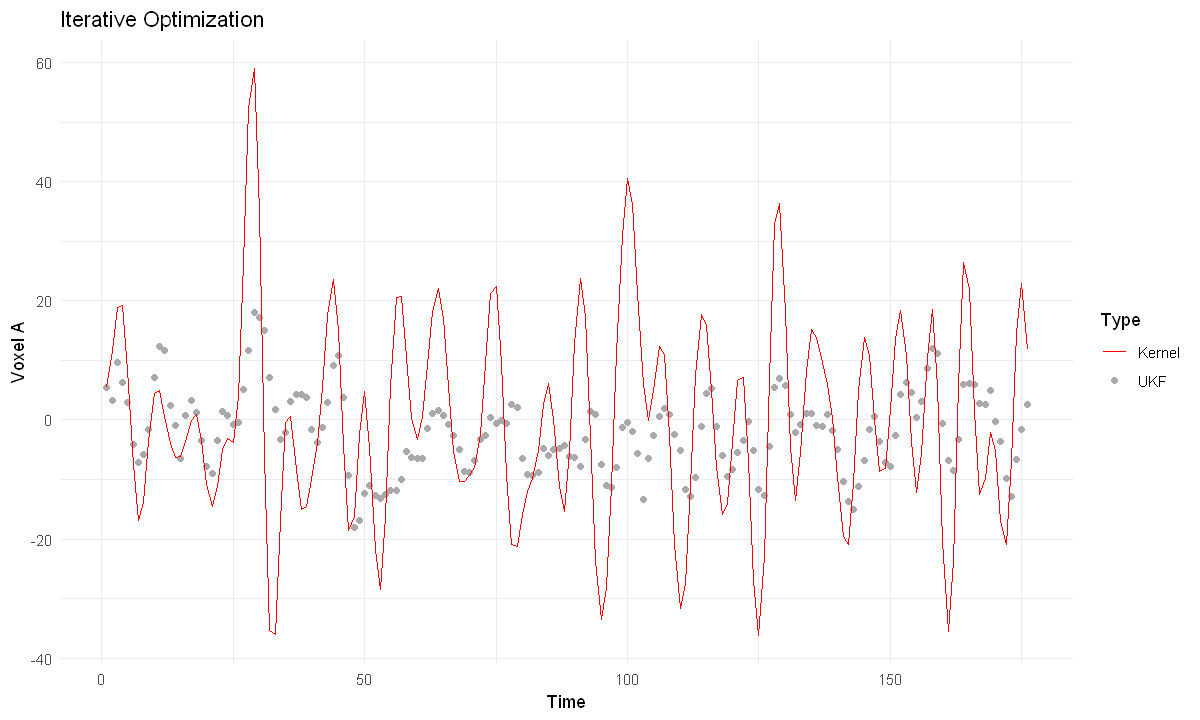

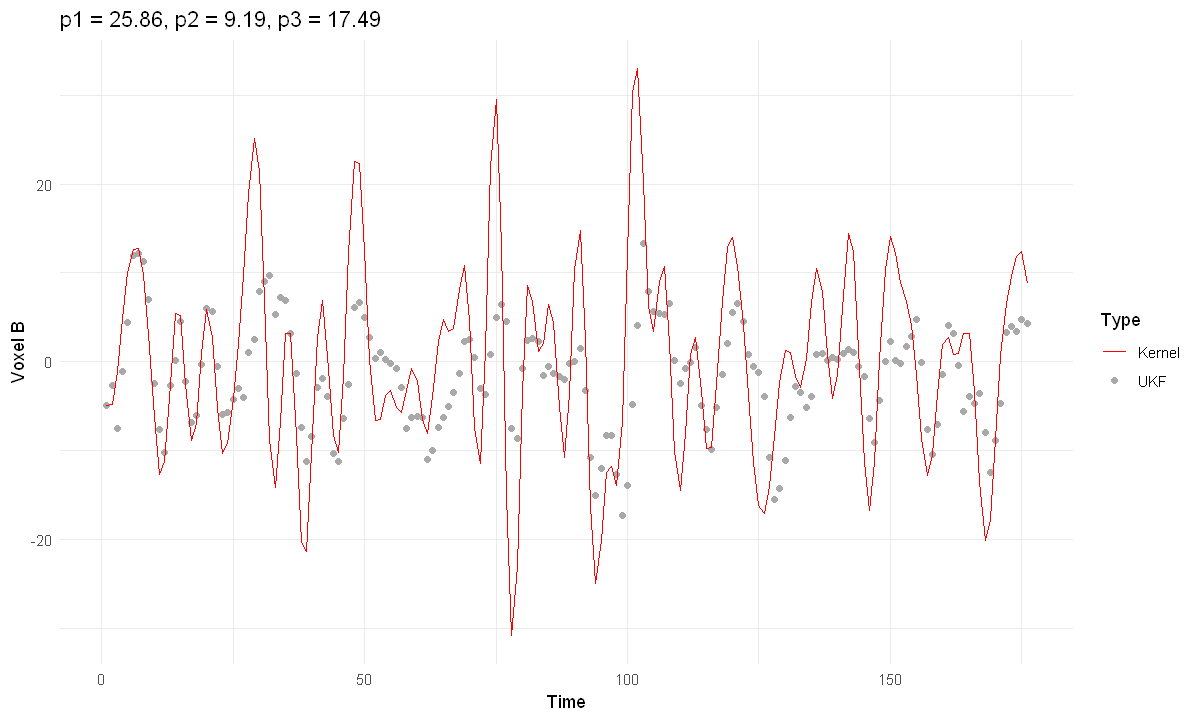

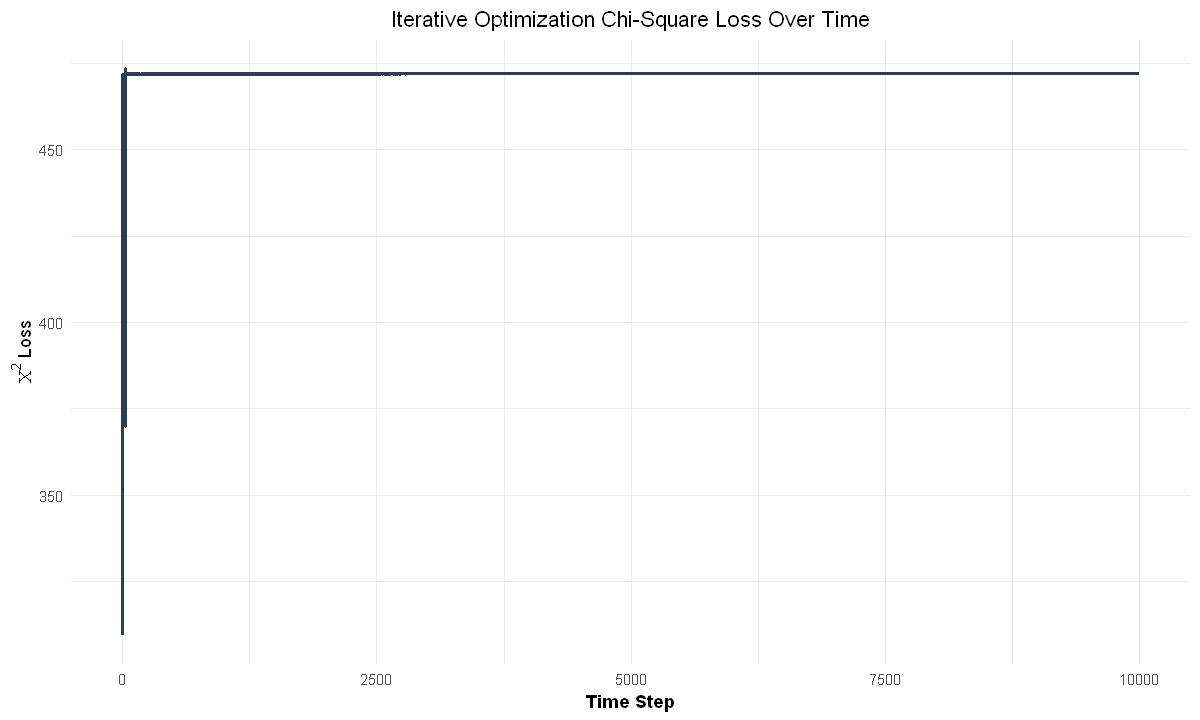

In [34]:
t_vec <- ukf_data[,1]
dT <- t_vec[2]-t_vec[1]
dt <- 0.1*dT
N_y <- ncol(ukf_data)-1
N_p <- 3
param_guess <- c(10,10,40) # g, L, k
iter_opt <- iterative_param_optim_trace(param_guess, t_dummy, ukf_data, coupled_osc_model, N_p, N_y, dt, dT,
                                  param_tol = 1e-5, MAXSTEPS = 10000, forcePositive = TRUE)

cat("Iterative Parameter Optimization Results:\n")
cat("=========================================\n")
cat("Estimated Parameters:\n")
cat(" g  : ", iter_opt$param_est[1], "\n")
cat(" L : ", iter_opt$param_est[2], "\n")
cat(" k  : ", iter_opt$param_est[3], "\n")
cat("\nChi-Square Value: ", iter_opt$value)
cat("\nNumber of Steps: ", iter_opt$steps)
cat("\nParameter Norm: ", iter_opt$param_norm)
cat("\n=========================================\n")

# Plot the results
plot_ukf_and_smoothed_ggplot(iter_opt, ukf_data, top_title = 'Iterative Optimization')
plot_ukf_chi_square_loss(iter_opt, title = "Iterative Optimization Chi-Square Loss Over Time")

3 parameter estimation, tolerance = 0.00001, Maximum #iterations = 10000 did not converge, also did not find better parameters, increase #iterations

3 parameter estimation, tolerance = 0.00001, Maximum #iterations = 100000, 40.55 mins runtime

Iterative Parameter Optimization Results:
Estimated Parameters:
 g  :  25.85544 
 L :  9.189006 
 k  :  17.49393 

Chi-Square Value:  309.4349
Number of Steps:  10253
Parameter Norm:  6.392052e-06


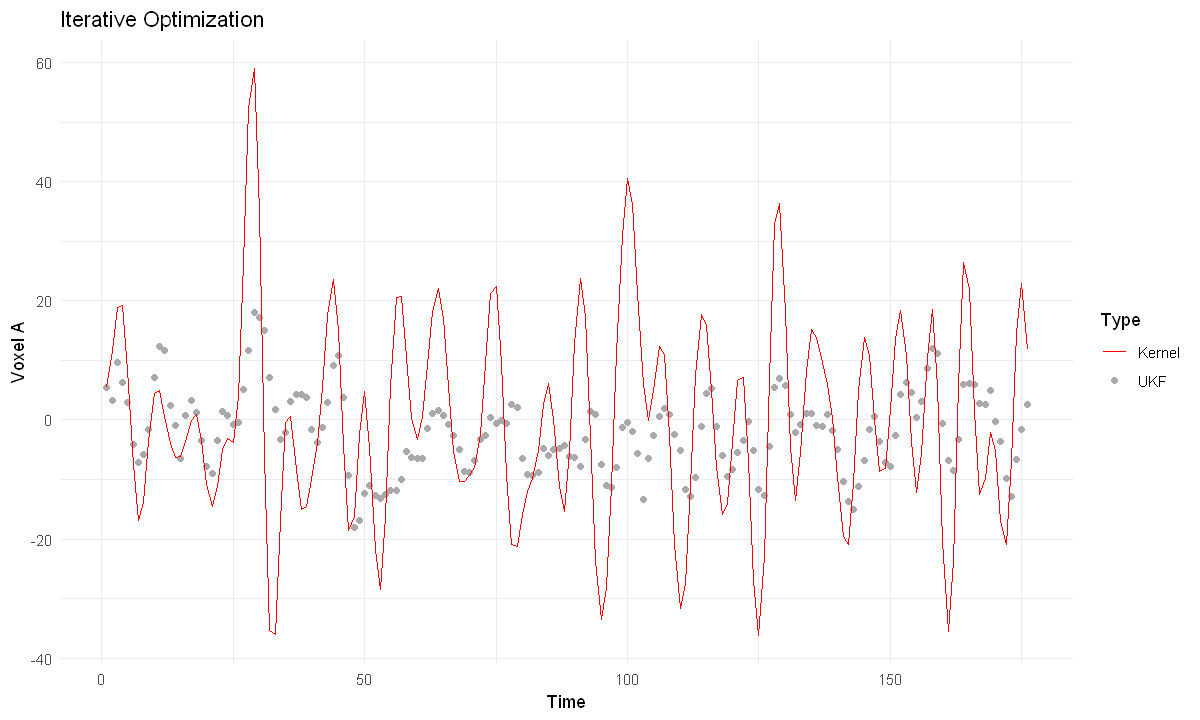

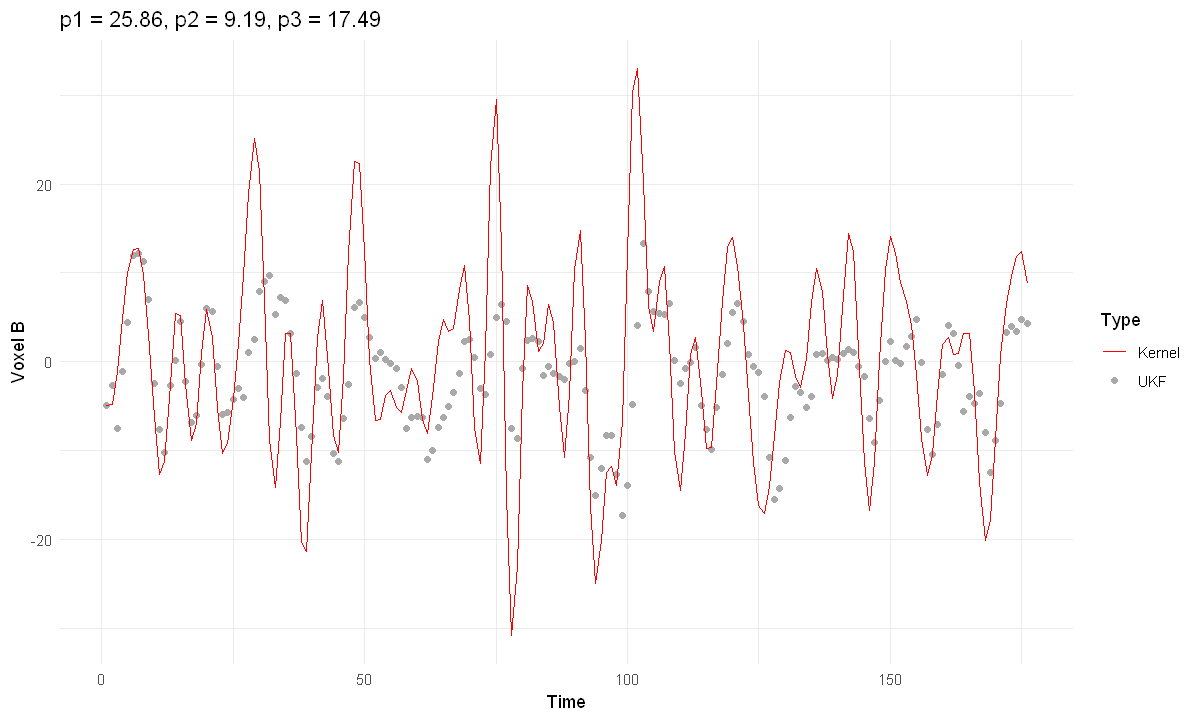

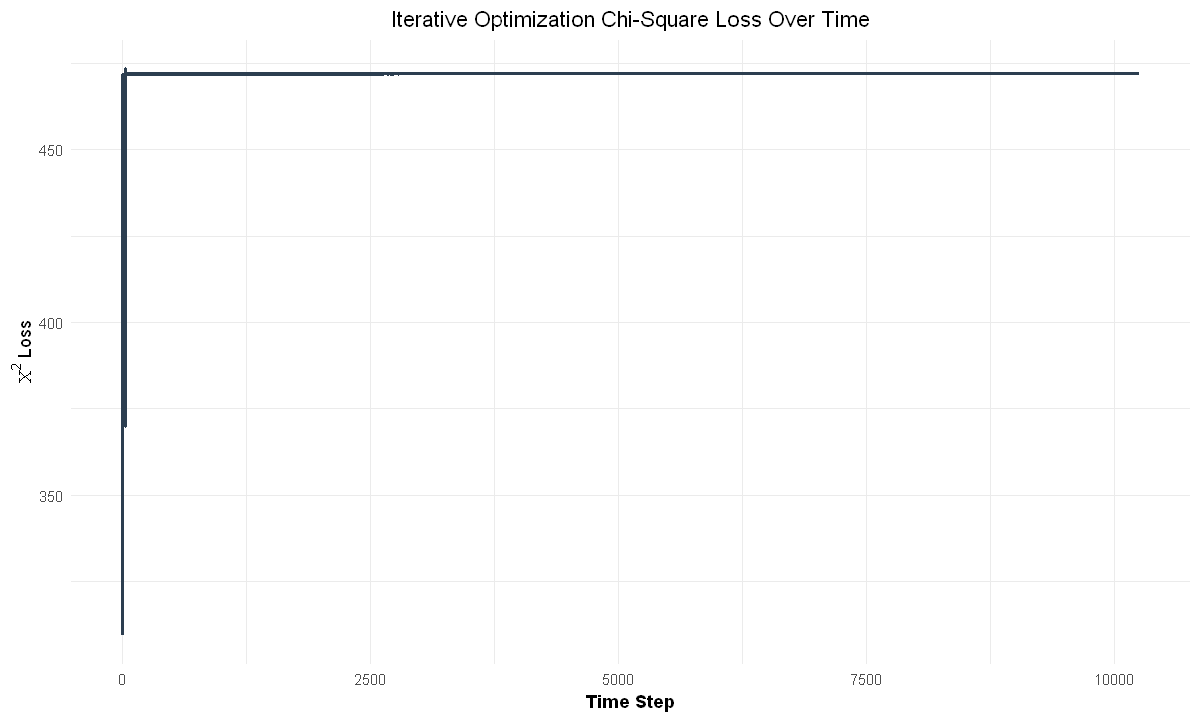

In [36]:
t_vec <- ukf_data[,1]
dT <- t_vec[2]-t_vec[1]
dt <- 0.1*dT
N_y <- ncol(ukf_data)-1
N_p <- 3
param_guess <- c(10,10,40) # g, L, k
iter_opt <- iterative_param_optim_trace(param_guess, t_dummy, ukf_data, coupled_osc_model, N_p, N_y, dt, dT,
                                  param_tol = 1e-5, MAXSTEPS = 100000, forcePositive = TRUE)

cat("Iterative Parameter Optimization Results:\n")
cat("=========================================\n")
cat("Estimated Parameters:\n")
cat(" g  : ", iter_opt$param_est[1], "\n")
cat(" L : ", iter_opt$param_est[2], "\n")
cat(" k  : ", iter_opt$param_est[3], "\n")
cat("\nChi-Square Value: ", iter_opt$value)
cat("\nNumber of Steps: ", iter_opt$steps)
cat("\nParameter Norm: ", iter_opt$param_norm)
cat("\n=========================================\n")

# Plot the results
plot_ukf_and_smoothed_ggplot(iter_opt, ukf_data, top_title = 'Iterative Optimization')
plot_ukf_chi_square_loss(iter_opt, title = "Iterative Optimization Chi-Square Loss Over Time")

3 parameter estimation, tolerance = 0.00001, Maximum #iterations = 100000 converged at 10253, decrease tolerance to 0.000001, decrease #iterations to 10000

3 parameter estimation, tolerance = 0.00001, Maximum #iterations = 10000, 40.34 mins runtime

Iterative Parameter Optimization Results:
Estimated Parameters:
 g  :  25.85544 
 L :  9.189006 
 k  :  17.49393 

Chi-Square Value:  309.4349
Number of Steps:  10000
Parameter Norm:  0.3669116


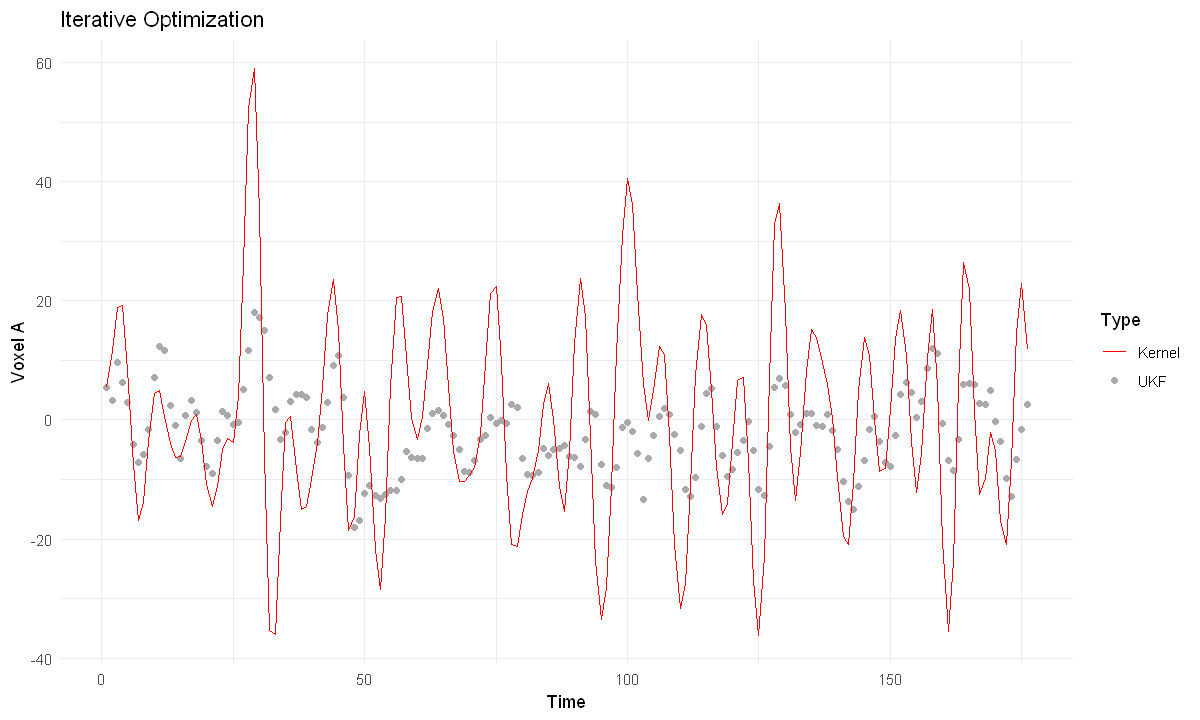

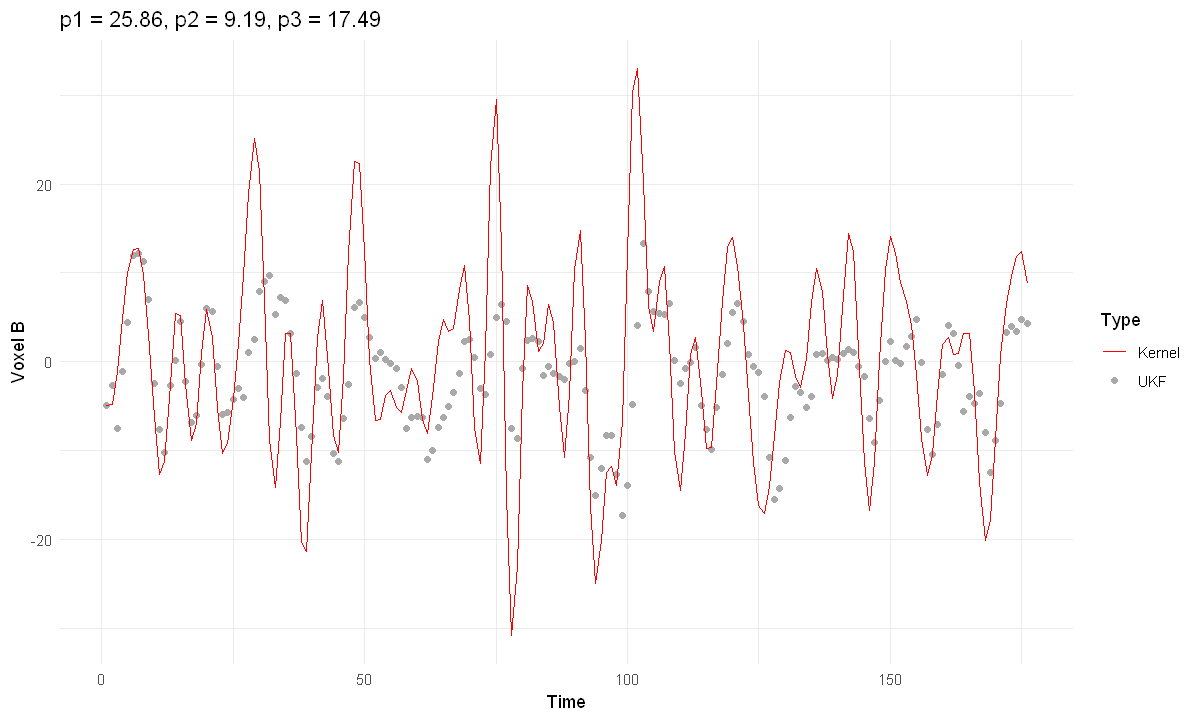

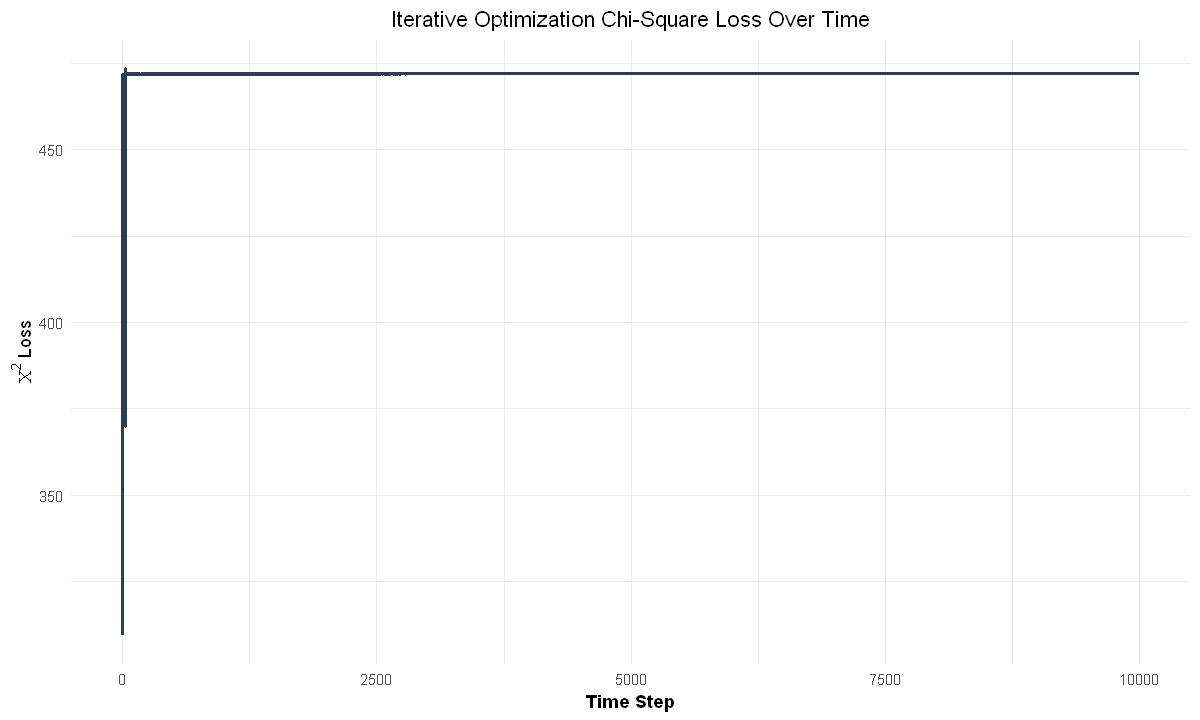

In [37]:
t_vec <- ukf_data[,1]
dT <- t_vec[2]-t_vec[1]
dt <- 0.1*dT
N_y <- ncol(ukf_data)-1
N_p <- 3
param_guess <- c(10,10,40) # g, L, k
iter_opt <- iterative_param_optim_trace(param_guess, t_dummy, ukf_data, coupled_osc_model, N_p, N_y, dt, dT,
                                  param_tol = 1e-6, MAXSTEPS = 10000, forcePositive = TRUE)

cat("Iterative Parameter Optimization Results:\n")
cat("=========================================\n")
cat("Estimated Parameters:\n")
cat(" g  : ", iter_opt$param_est[1], "\n")
cat(" L : ", iter_opt$param_est[2], "\n")
cat(" k  : ", iter_opt$param_est[3], "\n")
cat("\nChi-Square Value: ", iter_opt$value)
cat("\nNumber of Steps: ", iter_opt$steps)
cat("\nParameter Norm: ", iter_opt$param_norm)
cat("\n=========================================\n")

# Plot the results
plot_ukf_and_smoothed_ggplot(iter_opt, ukf_data, top_title = 'Iterative Optimization')
plot_ukf_chi_square_loss(iter_opt, title = "Iterative Optimization Chi-Square Loss Over Time")

3 parameter estimation, tolerance = 0.00001, Maximum #iterations = 100000 did not converge in 10000 #iterations. Increase #iterations to 100000

3 parameter estimation, tolerance = 0.00001, Maximum #iterations = 100000, 511.18 mins runtime

Iterative Parameter Optimization Results:
Estimated Parameters:
 g  :  25.85544 
 L :  9.189006 
 k  :  17.49393 

Chi-Square Value:  309.4349
Number of Steps:  1e+05
Parameter Norm:  0.9922567


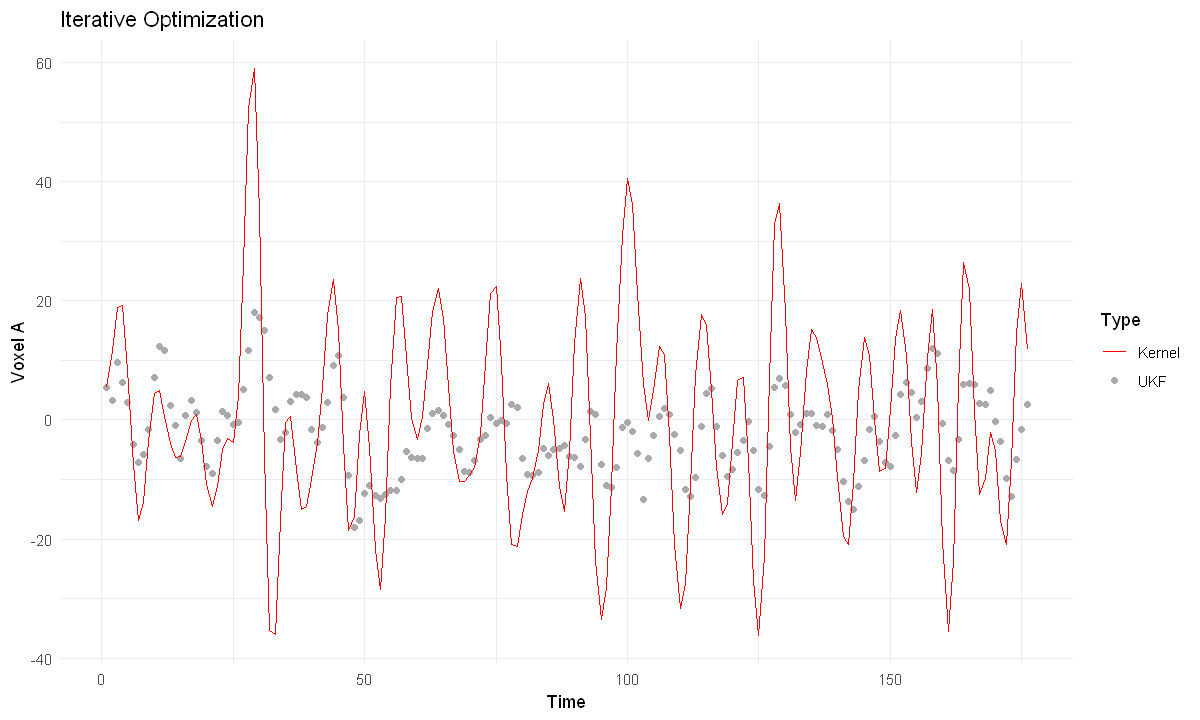

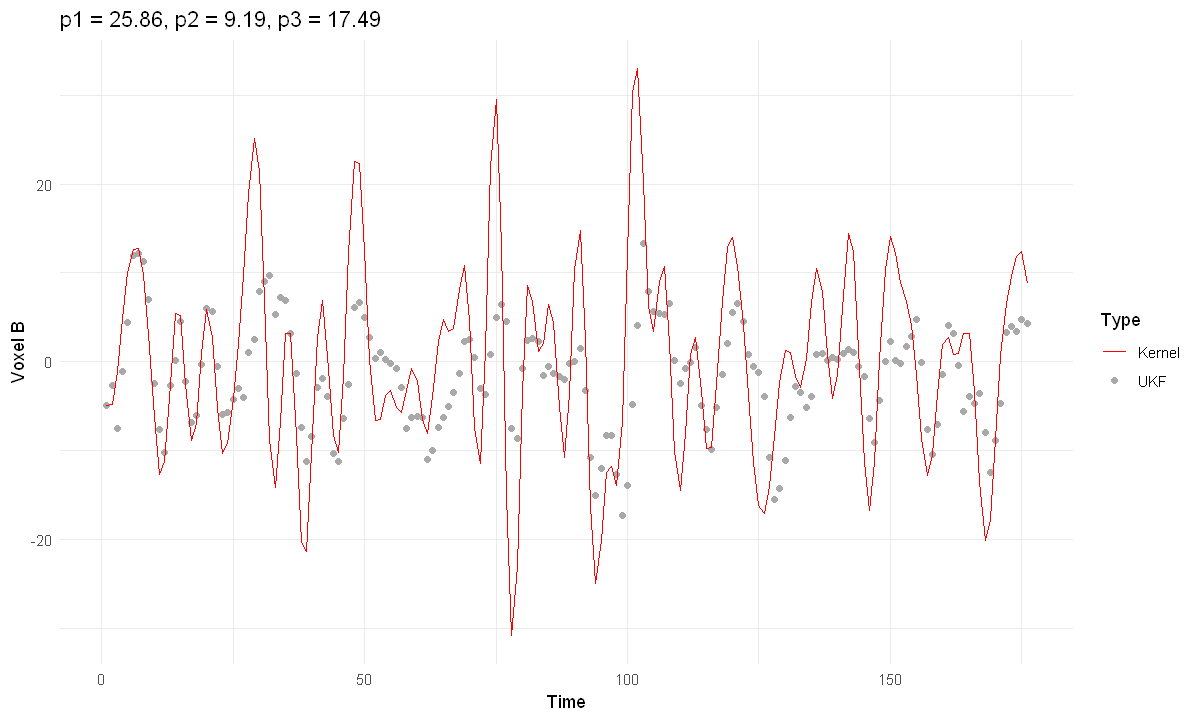

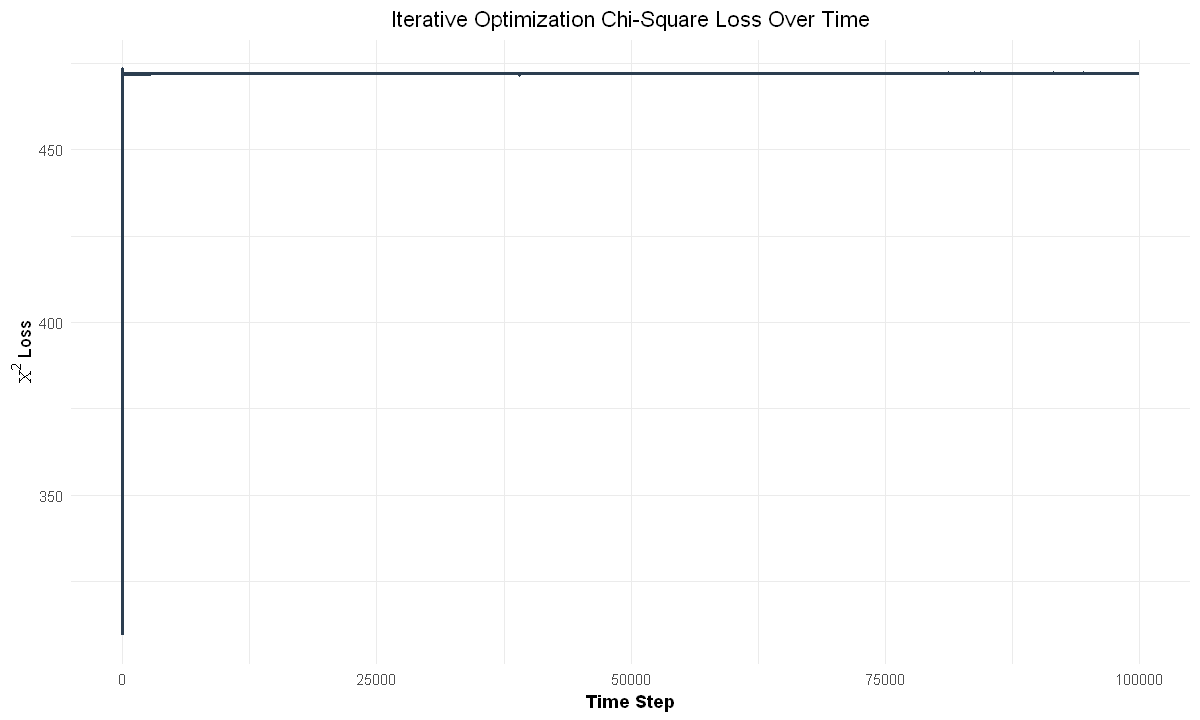

In [38]:
t_vec <- ukf_data[,1]
dT <- t_vec[2]-t_vec[1]
dt <- 0.1*dT
N_y <- ncol(ukf_data)-1
N_p <- 3
param_guess <- c(10,10,40) # g, L, k
iter_opt <- iterative_param_optim_trace(param_guess, t_dummy, ukf_data, coupled_osc_model, N_p, N_y, dt, dT,
                                  param_tol = 1e-6, MAXSTEPS = 100000, forcePositive = TRUE)

cat("Iterative Parameter Optimization Results:\n")
cat("=========================================\n")
cat("Estimated Parameters:\n")
cat(" g  : ", iter_opt$param_est[1], "\n")
cat(" L : ", iter_opt$param_est[2], "\n")
cat(" k  : ", iter_opt$param_est[3], "\n")
cat("\nChi-Square Value: ", iter_opt$value)
cat("\nNumber of Steps: ", iter_opt$steps)
cat("\nParameter Norm: ", iter_opt$param_norm)
cat("\n=========================================\n")

# Plot the results
plot_ukf_and_smoothed_ggplot(iter_opt, ukf_data, top_title = 'Iterative Optimization')
plot_ukf_chi_square_loss(iter_opt, title = "Iterative Optimization Chi-Square Loss Over Time")

g fixed = 25.85544, L_fixed = 9.189006, initial k = 17.49393

Iterative Parameter Optimization Results:
Estimated Parameters:
 k  :  214.2853 

Chi-Square Value:  248.8577
Number of Steps:  1000
Parameter Norm:  7.261932


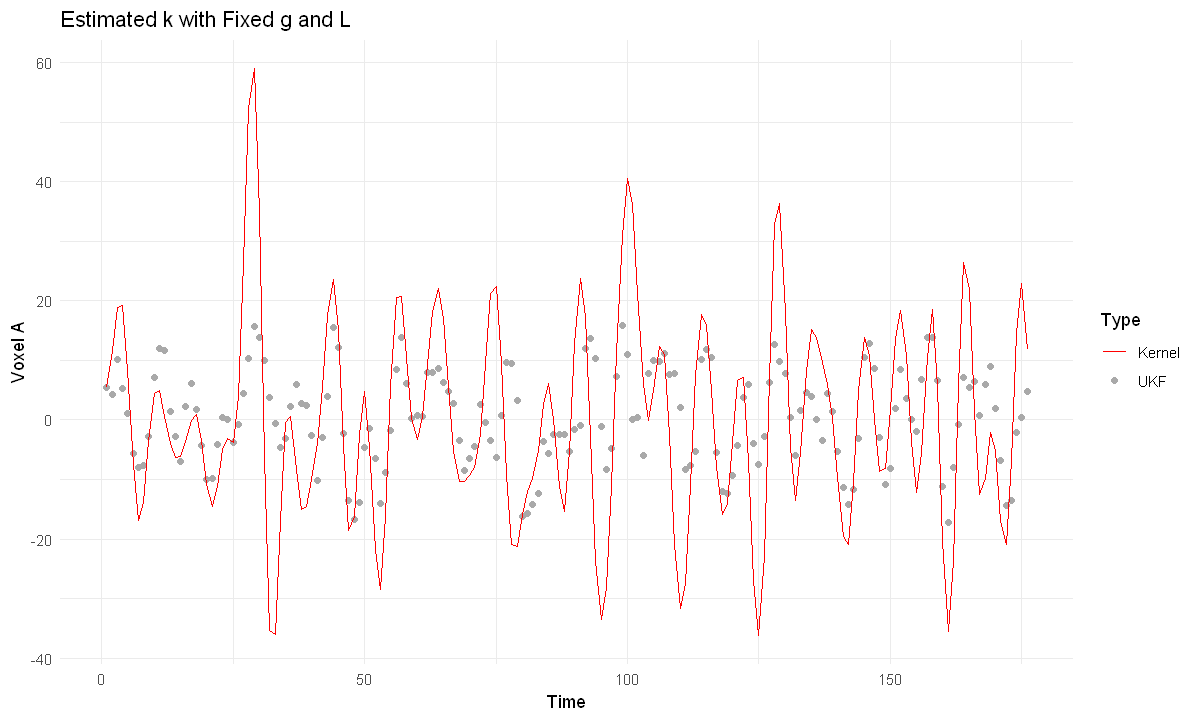

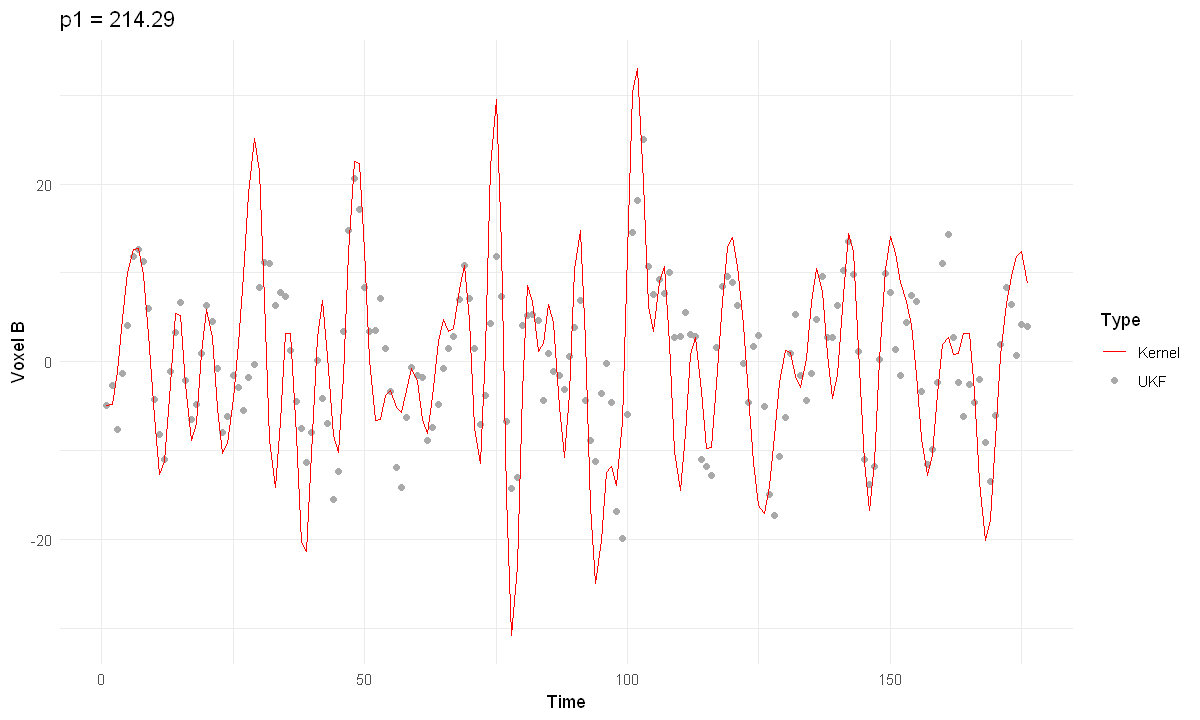

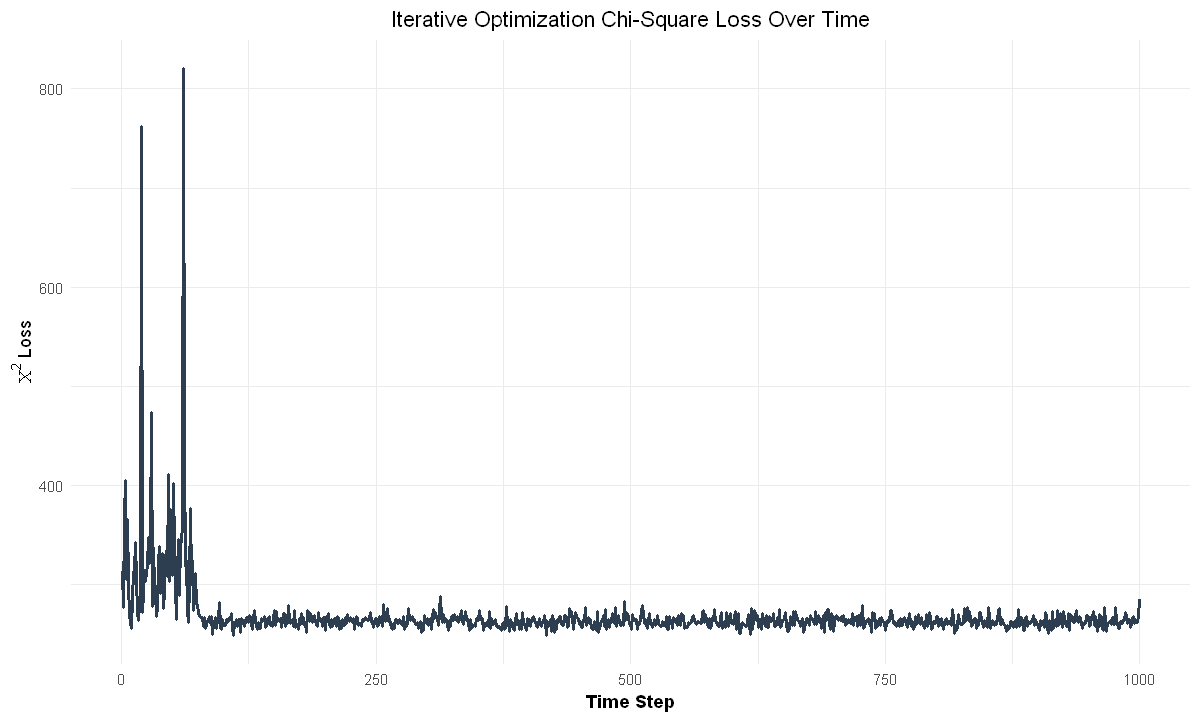

In [39]:
# model parameters
g_fixed <- 25.85544
L_fixed <- 9.189006
param_guess <- 17.49393  # Initial guess for k

# UKF parameters
N_p <- 1  # Only k
N_y <- 2  # Two regions
dt <- 0.1 * (ukf_data[2,1] - ukf_data[1,1])
dT <- ukf_data[2,1] - ukf_data[1,1]
t_dummy <- 0  

# Run UKF iterative parameter optimization
iter_opt <- iterative_param_optim_trace(
  param_guess, t_dummy, ukf_data, coupled_osc_model_fixed,
  N_p, N_y, dt, dT, param_tol = 1e-4, MAXSTEPS = 1000,
  forcePositive = TRUE
)

cat("Iterative Parameter Optimization Results:\n")
cat("=========================================\n")
cat("Estimated Parameters:\n")
cat(" k  : ", iter_opt$param_est[1], "\n")
cat("\nChi-Square Value: ", iter_opt$value)
cat("\nNumber of Steps: ", iter_opt$steps)
cat("\nParameter Norm: ", iter_opt$param_norm)
cat("\n=========================================\n")

# Plot results
options(repr.plot.width=10, repr.plot.height=6)
plot_ukf_and_smoothed_ggplot(iter_opt, ukf_data, top_title = 'Estimated k with Fixed g and L')
plot_ukf_chi_square_loss(iter_opt, title = "Iterative Optimization Chi-Square Loss Over Time")

Iterative Parameter Optimization Results:
Estimated Parameters:
 k  :  11776.14 

Chi-Square Value:  246.6272
Number of Steps:  9524
Parameter Norm:  5.866319e-05


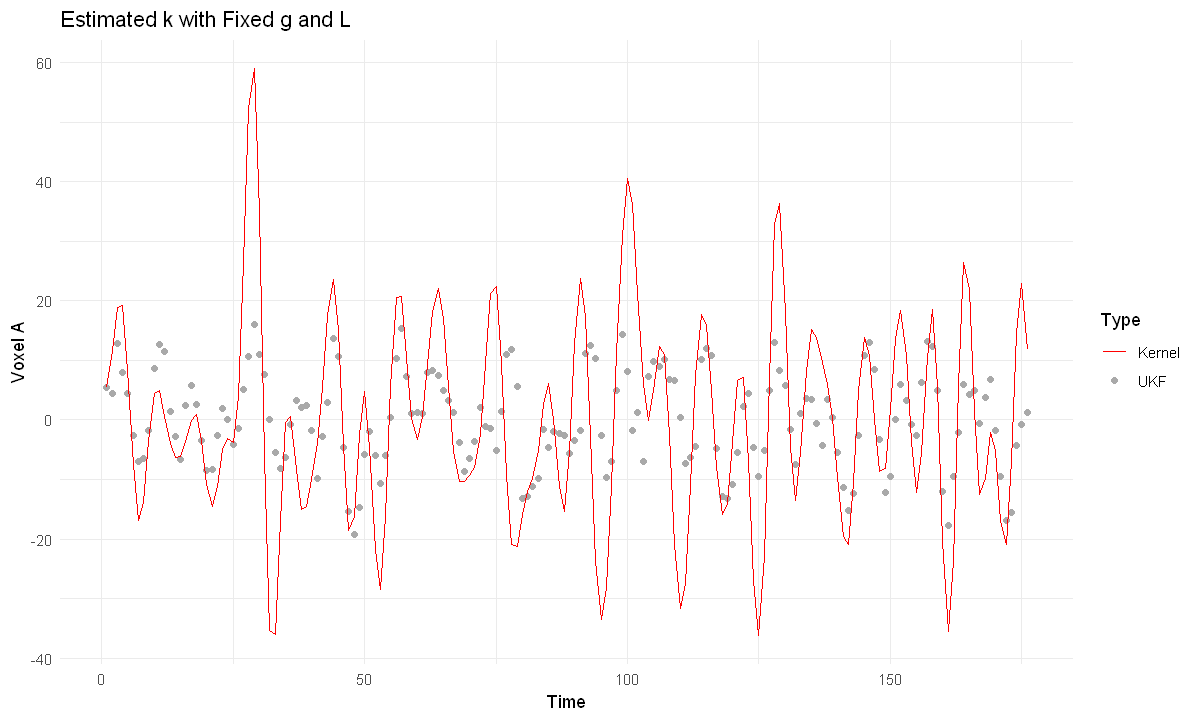

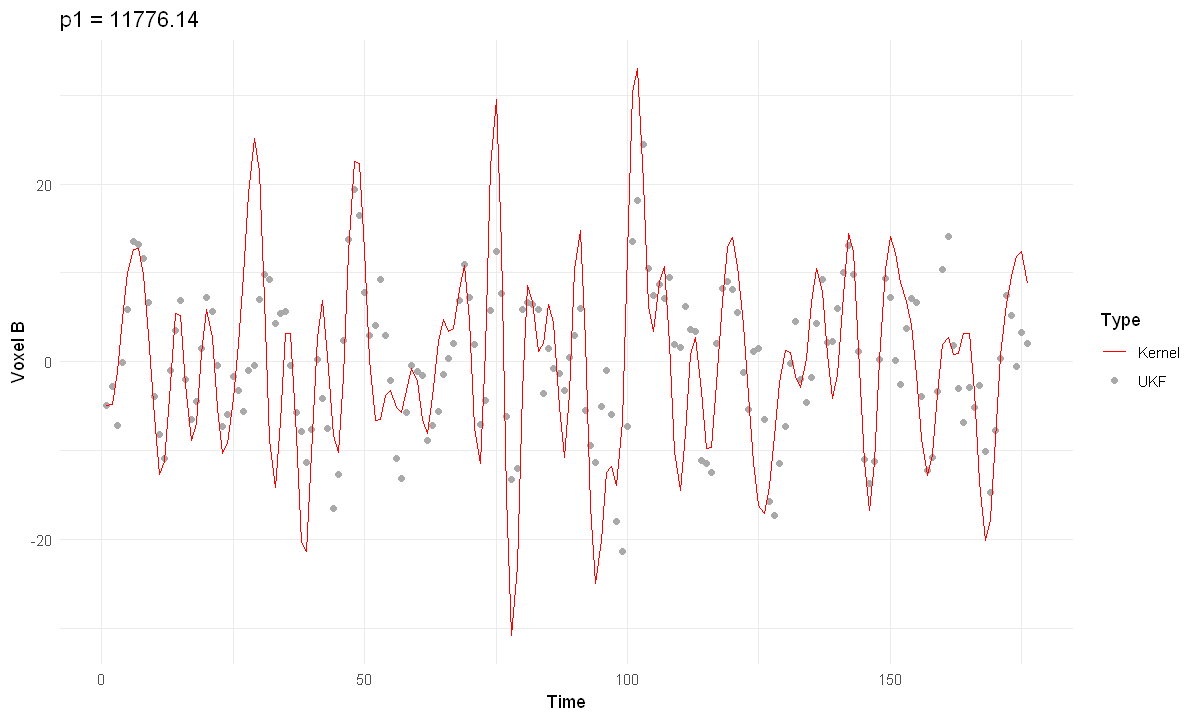

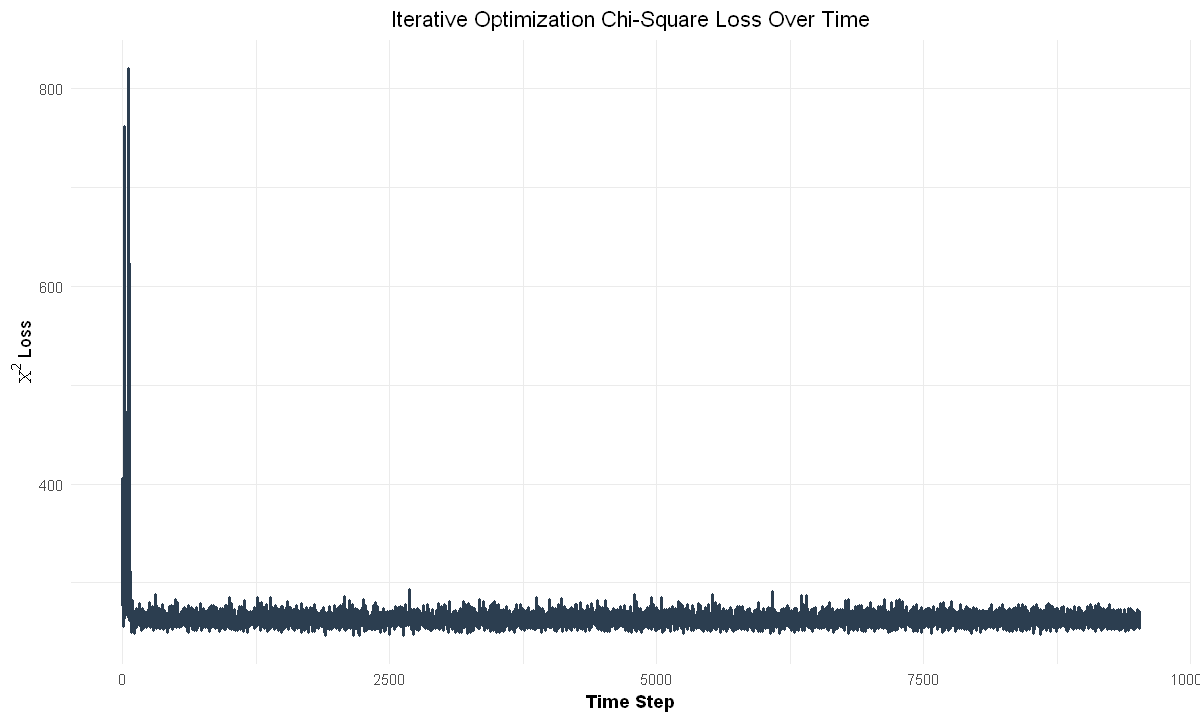

In [40]:
# model parameters
g_fixed <- 25.85544
L_fixed <- 9.189006
param_guess <- 17.49393  # Initial guess for k

# UKF parameters
N_p <- 1  # Only k
N_y <- 2  # Two regions
dt <- 0.1 * (ukf_data[2,1] - ukf_data[1,1])
dT <- ukf_data[2,1] - ukf_data[1,1]
t_dummy <- 0  

# Run UKF iterative parameter optimization
iter_opt <- iterative_param_optim_trace(
  param_guess, t_dummy, ukf_data, coupled_osc_model_fixed,
  N_p, N_y, dt, dT, param_tol = 1e-4, MAXSTEPS = 10000,
  forcePositive = TRUE
)

cat("Iterative Parameter Optimization Results:\n")
cat("=========================================\n")
cat("Estimated Parameters:\n")
cat(" k  : ", iter_opt$param_est[1], "\n")
cat("\nChi-Square Value: ", iter_opt$value)
cat("\nNumber of Steps: ", iter_opt$steps)
cat("\nParameter Norm: ", iter_opt$param_norm)
cat("\n=========================================\n")

# Plot results
options(repr.plot.width=10, repr.plot.height=6)
plot_ukf_and_smoothed_ggplot(iter_opt, ukf_data, top_title = 'Estimated k with Fixed g and L')
plot_ukf_chi_square_loss(iter_opt, title = "Iterative Optimization Chi-Square Loss Over Time")